# Расшифровка VIN-кода. Определение стоимости транспортного средства по VIN-коду
Небольшой магазин специализируется на продаже транспортных средств с пробегом марки **Ford**, произведенных исключительно в Северной Америке. Менеджерам магазина необходимо проверять информацию, оставляемую потенциальными клиентами-продавцами машин, и сообщать им приблизительную стоимость. Проверка осуществляется по VIN-коду, так как остальную информацию клиенты могут указать не корректно. В настоящее время проверка проводится по таблицам Ford, цена рассчитывается вручную,

**Задача**:
1. Автоматизировать проверку VIN-кода на валидность:
  - формат
  - марка машины **Ford**
  - машина произведена в Северной Америке
2. Расшифровать VIN-код для наглядности
3. Построить модель для определения стоимости автомобиля.<br>

**Описание данных**
Для построения модели имеются исторические данные, содержащие цены и VIN-коды машин **Ford** Северо-Американского производства.


In [1]:
#!pip install -q catboost
#!pip install -q phik

In [2]:
# import libraries
import os
import re

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

In [3]:
# display settings
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.precision", 4)

%matplotlib inline

In [4]:
# set random state
RANDOM_STATE = 42

# data path
PATH = ['Datasets']

# dataset name
FORD = 'vin_ford_train.txt'

## Загрузка и анализ данных
Загрузим текстовый файл и посмотрим на его содержание.

In [5]:
# open file to read
with open(os.path.join(*PATH, FORD), 'r') as f:
  data = f.read()

In [6]:
# first 500 characters
data[:500]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]правил [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600][1FDNE1BW5BDA64735:13200'

Видно, что
- данные представлены в формате **[VIN-code:price]**
- имеются нерелевантные данные - слова между блоками код:цена

VIN-код (Vehicle identification number) - идентификационный номер транспортного средства, уникальный код транспортного средства, состоящий из 17 знаков. В коде представлены сведения о производителе и характеристиках транспортного средства, а также о годе выпуска. [Подробнее](https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes))<br>

**Основные особенности:**
- VIN-код  состоит из 17 знаков – цифр и букв, кроме 'I', 'O', 'Q'
- Последние три знака – всегда цифры
- Год не содержит также буквы 'Z' и 'U'

**Особенности Северо-Американских кодов:**<br>
1-3: wmi, идентификатор производителя, начинается с цифр 1-5<br>
*1A-10 США, 2A-20 Канада, 3A-3W Мексика, 3X-37 Коста Рика, 38-30 Каймановы острова, 4A-40 США, 5A-50 США*<br>
4-9: vds, описание транспортного средства<br>
  4: полная масса/тип тормозной системы или установленные системы безопасностити
  5-7: модель (линия, серия ...)<br>
  8: тип двигателя<br>
  9: контрольная цифра<br>
10: модельный год (с 1980го)<br>
11: идентификатор завода-производителя<br>
12-17: vis, идентификатор конкретного транспортного средства<br>







На данном этапе загрузим лишь корректные данные, проверяя общий формат vin-кода и цены.

Создадим строку с "разрешенными" символами.

In [7]:
# allowed charackters
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ['I', 'O', 'Q']]
ALLOWED = ''.join(ALLOWED_CHARS)+'1234567890'
ALLOWED

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

Создадим регулярное выражения для выделения отдельных компонентов вин-кода и цены.

In [8]:
# regexs for different parts of vin
WMI_RE = f'(?P<wmi>[{ALLOWED}]{{3}})'         # wim, 3 chars from allowed
RESTRAINT_RE = f'(?P<restraint>[{ALLOWED}])'  # restraint/brake systems, 1 char from allowed
MODEL_RE = f'(?P<model>[{ALLOWED}]{{3}})'     # model of vehicle, 3 chars from allowed
ENGINE_RE = f'(?P<engine>[{ALLOWED}])'        # engine, 1 char from allowed
CHECK_RE = f'(?P<check>[{ALLOWED}])'          # check digit, 1 char from allowed
YEAR_RE = f'(?P<year>[{ALLOWED.replace("U", "").replace("Z", "")}])' # year, 1 char from allowed without 'U' and 'Z'
PLANT_RE = f'(?P<plant>[{ALLOWED}])'          # plant, 1 char from allowed
VIS_RE = f'(?P<vis>[{ALLOWED}]{{3}}\\d{{3}})' # vis, 3 chars from allowed+3digits

In [9]:
# regexs to parse vin and price
VIN_RE = f'{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}'
PRICE_RE = r'(?P<price>\d+)'

# complite pattern
pattern = re.compile(f'\\[{VIN_RE}:{PRICE_RE}\\]')

Создадим датафрейм из имеющегося текстового файла, разбив вин-код на составляющие и выделив цену.

In [10]:
# list of dicts
data_dicts = []
for vin in pattern.finditer(data):
  data_dicts.append(vin.groupdict())

# create data frame
df = pd.DataFrame(data_dicts)
df.head()

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [11]:
# information about the data
display(df.info())

# check for duplicates
if df.drop('price', axis=1).duplicated().sum() > 0:
  print('В данных есть явные дубликаты')
else:
  print('В данных нет явных дубликатов')

# number of unique values
print('\nКоличество уникальных значений')
display(df.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


None

В данных нет явных дубликатов

Количество уникальных значений


wmi             14
restraint       26
model          365
engine          32
check           11
year            25
plant           21
vis          68215
price          643
dtype: int64

Имеется почти 72000 разных машин, нет пропущенных значений. Цену можно перевести в числовой формат, а остальные данные - в категориальный (пока оставим *'object'*).

Есть 14 производителей и 365 моделей машин; стоит обратить внимание, что разных годов всего 25, а c 1980 прошло уже 44 года - начиная с 2010 года маркировка года повто ряется. Некоторое количество серийных номеров (vis) повторяется, но но такие машины будут различаться благодаря другим частям кода. Разных цен всего 643, что может указывать на то, что цену указывают в определенном диапазоне.

In [12]:
# convert price to integer
df['price'] = df['price'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 4.9+ MB


Посмотрим, как распределены признаки, какие есть особенности.

- **Цена автомобилей**

Поскольку магазин продает Северо-Американские машины, предположим, что цена в долларах.



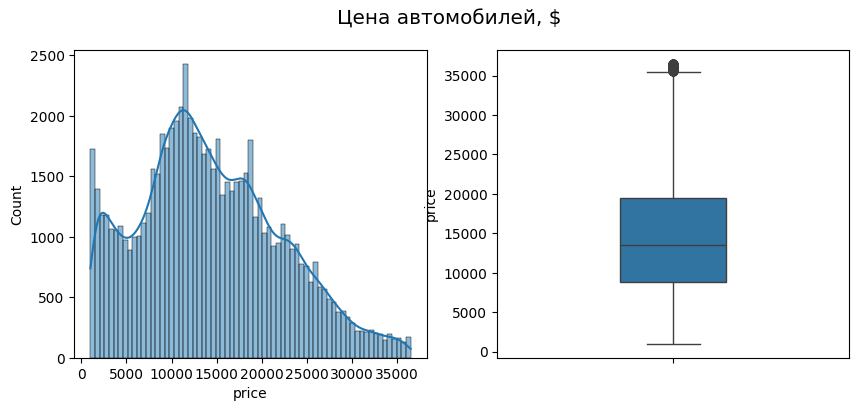

count    71884.0000
mean     14321.4494
std       7827.0572
min       1000.0000
25%       8800.0000
50%      13500.0000
75%      19500.0000
max      36500.0000
Name: price, dtype: float64

In [13]:
# distribution histogram
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Цена автомобилей, $", fontsize="x-large")

# boxplot
sns.histplot(data=df, x='price', kde=True, ax=axs[0])
sns.boxplot(data=df['price'], width=0.3, ax=axs[1]).set(xticklabels=[])
plt.tight_layout
plt.show()

# descriptive statistics
df['price'].describe()

Цены распределены практически нормально, средняя цена 14321, медианная 13500. Значительных выбросов нет, есть пик около минимальных цен (1000) - машины продают за символическую плату, дорогих машин не много.

Посмотрим на признаки, например, есть ли редкие значения, какие значения встречаются наиболее и наименее часто.





In [14]:
# top 3 and bottom 5 values
for col in df.drop(['check', 'vis','price'], axis=1).columns:
  display(df[col].value_counts().iloc[np.r_[0:5, -5:0]])

wmi
1FM    18347
1FT    17177
1FA    12844
3FA    12404
2FM     5829
2FA      199
2FT      145
4N2       22
4F4       16
3FT       15
Name: count, dtype: int64

restraint
D    12370
H    12012
C     9034
F     8376
6     5890
M      189
V       80
X       67
A        3
4        1
Name: count, dtype: int64

model
P0H    6171
P3F    3931
W1E    3897
P3K    1958
P0J    1487
R2Y       1
X15       1
K30       1
P7A       1
F25       1
Name: count, dtype: int64

engine
2    7015
8    6101
C    4806
7    4564
9    4512
4     309
H     298
S     178
Y      29
B       9
Name: count, dtype: int64

year
D    17286
E    14990
C    12254
B     5860
8     3277
S       20
R        6
H        1
K        1
P        1
Name: count, dtype: int64

plant
R    10535
K     9112
L     8225
G     7265
U     6732
H      362
X      199
C      133
T       97
Y       80
Name: count, dtype: int64

In [15]:
print('Количество машин уникальной модели')
sum(df.model.value_counts()==1)

Количество машин уникальной модели


19

Распределение количество машин разных характеристик неравномерно. Большинство машин произведены в основном 4-5 производителями на 5-6 заводах, самая популярная модель в два раза "популярнее последующих, при этом есть19 уникальных моделей. Имеется 4 основных типа системобеспечения безопасности/тормозов и два наиболее популярных двигателя.

Признаки транспортных средств представлены закодированными значениями. Для предоставления информации о транспортном средстве, исходя из vin-кода, можно их "расшифровать", взяв данные из открытых источников.
Однако для построения базовой модели можно использовать как есть.

Посмотрим, какие **признаки коррелируют с ценой**<br>
Не будем включать в анализ проверочную цифру и серийный номер транспортного средства, так как они вряд ли влияют на цену.

In [16]:
# Phik correlation coefficients matrix
phik_overview = df.drop(['check', 'vis'], axis=1).phik_matrix()

interval columns not set, guessing: ['price']


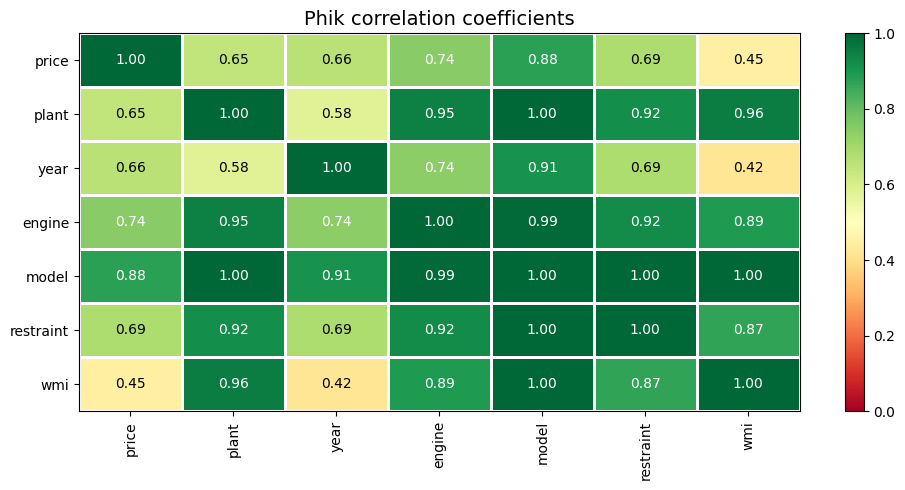

In [17]:
# Plot Phik correlation coefficients matrix
plot_correlation_matrix(phik_overview.values,
                        x_labels=('wmi', 'restraint', 'model', 'engine',
                                  'year', 'plant', 'price'),
                        y_labels=('wmi', 'restraint', 'model', 'engine',
                                  'year', 'plant', 'price'),
                        title="Phik correlation coefficients",
                        figsize=(10, 5),
                        vmin=0, vmax=1)

Наибольшая корреляция с ценой видна для модели машин, что логично, цена также сильно коррелирует с типом мотора. Видно, что определенные заводы производят определенные модели машин с определенными двигателями и типами систем безопасности/тормозов/веса.
Модельный год связан с моделью и двигателем, а в определенной стране/кампании производят конкретные модели.

### Вывод

Были загружены и проанализированы данные, содержащие vin-коды и цены машин Ford северо-американского производства.
- имеются данные для около 72000 машин
- распределение цен близко к нормальному, существенных выбросов нет
- в признаках имеются уникальные категории, количество машин неравномерно для разных категорий разных признаков
- есть 14 разных производителя, 365 разных моделей машин, 19 из которых уникальны
- наиболее корелируют с ценой модель машины и тип двигателя

Можно попробовать построить модель, предсказывающую стоимость машины, ТОЛЬКО на основе данных VIN-кода, не затрачивая время на его расшифровку.

## Базовая модель

Исходя только из даннных, извлеченных из vin-кодов, построим модель для предсказания цены автомобиля.

Протестируем 2 модели градиентного бустинга - CatBoost и LightGBM с разными гипермараметрами. Для выбора модели регрессии используем pipeline. Качество моделей оценим по метрике **RMSE** и сравним с константной моделью.

In [18]:
# train/test split
df_train, df_test = train_test_split(df, test_size=0.25,
                                     shuffle=True, random_state=RANDOM_STATE)

# sizes of training/test data
print('Размеры выборок:')
df_train.shape, df_test.shape

Размеры выборок:


((53913, 9), (17971, 9))

Не будем брать в качестве признаков проверочную цифру и серийный номер транспортного средства, так как они вряд ли влияют на цену.

In [19]:
# target and features
X_train = df_train.drop(['check', 'vis', 'price'], axis=1)
X_test = df_test.drop(['check', 'vis', 'price'], axis=1)
y_train, y_test = df_train['price'], df_test['price']

In [20]:
# categorical features
cat1 = list(X_train.select_dtypes('object'))

In [21]:
# Create the pipeline
pipeline = Pipeline([('regr', DummyRegressor())])

In [22]:
# Set grid search params
params = [
    {'regr': [LGBMRegressor(random_state=RANDOM_STATE, categorical_feature=cat1)],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': range(4, 12),
     'regr__num_leaves': range(35, 150),
     'regr__learning_rate': [0.01, 0.1, 0.3]},

    {'regr': [CatBoostRegressor(random_state=RANDOM_STATE, cat_features=cat1)],
     'regr__n_estimators': range(20, 200),
     'regr__depth': [4, 6, 8, 10, 12],
     'regr__learning_rate': [0.01, 0.1, 0.3],
     'regr__l2_leaf_reg': [0.2, 0.5, 1, 3]}]

In [23]:
# Construct grid search
scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
grid1 = RandomizedSearchCV(pipeline,
                          params,
                          cv=3,
                          verbose=False,
                          scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                          refit='neg_root_mean_squared_error',
                          n_jobs=-1,
                          random_state=RANDOM_STATE)

In [24]:
# Fit the grid search object
grid1.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklear

0:	learn: 7256.2394810	total: 106ms	remaining: 19.6s
1:	learn: 6768.0677322	total: 137ms	remaining: 12.6s
2:	learn: 6327.4208315	total: 168ms	remaining: 10.3s
3:	learn: 5955.2858834	total: 196ms	remaining: 8.91s
4:	learn: 5623.5119458	total: 226ms	remaining: 8.2s
5:	learn: 5334.3198839	total: 254ms	remaining: 7.62s
6:	learn: 5086.1189994	total: 283ms	remaining: 7.23s
7:	learn: 4861.8732292	total: 315ms	remaining: 7.01s
8:	learn: 4665.2771476	total: 345ms	remaining: 6.79s
9:	learn: 4449.9454401	total: 380ms	remaining: 6.68s
10:	learn: 4270.3445808	total: 437ms	remaining: 6.94s
11:	learn: 4115.2551631	total: 487ms	remaining: 7.06s
12:	learn: 3987.7315452	total: 547ms	remaining: 7.28s
13:	learn: 3874.9125257	total: 599ms	remaining: 7.36s
14:	learn: 3780.7943499	total: 660ms	remaining: 7.52s
15:	learn: 3700.4460104	total: 702ms	remaining: 7.46s
16:	learn: 3620.0046248	total: 768ms	remaining: 7.63s
17:	learn: 3552.4832606	total: 826ms	remaining: 7.71s
18:	learn: 3493.8036425	total: 884ms	re

RandomizedSearchCV(cv=3, estimator=Pipeline(steps=[('regr', DummyRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'regr': [LGBMRegressor(categorical_feature=['wmi',
                                                                                     'restraint',
                                                                                     'model',
                                                                                     'engine',
                                                                                     'year',
                                                                                     'plant'],
                                                                random_state=42)],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__max_depth': range(4, 12),
                                         'regr__n_estimators': range(20, 200, 10),
                                         'regr__num_leaves': rang...50)},
                                        {'regr': [<catboost.core.CatBoostRegressor object at 0x7a28a6125390>],
                                         'regr__depth': [4, 6, 8, 10, 12],
                                         'regr__l2_leaf_reg': [0.2, 0.5, 1, 3],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__n_estimators': range(20, 200)}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=False)

In [25]:
# Hyperparameters of the best model
print('Гиперпараметры лучшей модели:')
grid1.best_params_

Гиперпараметры лучшей модели:


{'regr__n_estimators': 186,
 'regr__learning_rate': 0.1,
 'regr__l2_leaf_reg': 0.5,
 'regr__depth': 8,
 'regr': <catboost.core.CatBoostRegressor at 0x7a28a6125390>}

In [26]:
# Print scores
print('RMSE:', round(abs(grid1.best_score_), 4))
print('MAPE:', round(abs(grid1.cv_results_['mean_test_neg_mean_absolute_percentage_error'][grid1.best_index_]),4))
print()
# Training time
time_fit = grid1.cv_results_['mean_fit_time'][grid1.best_index_]
print(f'Время обучения: {time_fit:.4f} s')

# Prediction time
time_pred = grid1.cv_results_['mean_score_time'][grid1.best_index_]
print(f'Время  предсказания: {time_pred:.4f} s')

RMSE: 2818.2743
MAPE: 0.2085

Время обучения: 8.2331 s
Время  предсказания: 0.0606 s


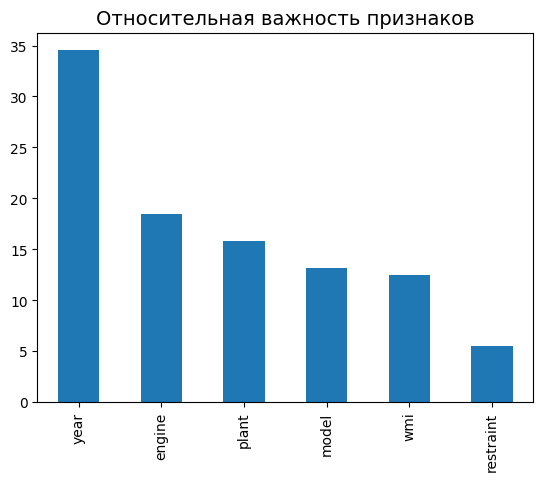

In [27]:
# Importance of the features
feature_importances = pd.DataFrame(
    {'features': list(X_train),
     'feature_importance': grid1.best_estimator_.named_steps['regr'].feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Относительная важность признаков', fontsize=14)
plt.xlabel('')
plt.show()

**Вывод**: По метрике качества RMSE лучшей моделью стал CatBoostRegressor из 186 деревьев максимальной глубиной 8 и при скорости обучения 0.1. Такая модель предсказывает конечную цену с ошибкой около 2820 на обучающей выборке и достаточно быстро обучается. Наибольшую важность для модели имели модельный год ТС и тип двигателя, эти признаки, вероятно, стоит "расшифровать". Тип систем безопасности имел наименьшее влияние.

In [28]:
# Evaluate the model
y_pred = grid1.predict(X_test)
print(f'Тестовая выборка MAPE = {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Тестовая выборка RMSE = {mean_squared_error(y_test, y_pred)**0.5}')

Тестовая выборка MAPE = 0.20773871702028
Тестовая выборка RMSE = 2810.3695108580714


Сравним полученную модель с константной.

In [29]:
# Predict with the dummy regressor (e.g., mean)
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

# Calculate scores
mape_dummy = mean_absolute_percentage_error(y_test, y_pred_dummy)
rmse_dummy = mean_squared_error(y_test, y_pred_dummy)**0.5

print(f'MAPE Dummy = {mape_dummy}')
print(f'RMSE Dummy = {rmse_dummy}')

MAPE Dummy = 1.0257382025645234
RMSE Dummy = 7839.305589736664


### Вывод
Модель предсказания цены ТС, только на основе полей, полученных из VIN-кода значительно лучше константной модели.  На тестовой выборке данная модель ошибается примерно на 2800, тогда как константная модель (предсказание всегда среднего) имеет ошибку 7840 (средняя цена 14321, стандартное отклонение 7827).

Для улучшения качества модели можно "расшифровать" vin-коды, выделив новые признаки. Видно, например, что год имеет большое значение для предсказания цены, но мы знаем, что код года не уникален, начиная с 2010 года буквы используются повторно. Также можно выделить характеристики двигателя.

##Расшифровка VIN-кода

Для этого потребуются референсные данные, есть pdf таблицы на официальном сайте Ford, но для удобства возьмем данные о расшифровке полей vin-кода со страницы в [Википедии](https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Ford/VIN_Codes#Passenger_Car_Identifiers), посвященной Ford.

###Референсные данные

Данные будем просто копировать из разных таблиц страницы в [Википедии](https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Ford/VIN_Codes#Passenger_Car_Identifiers)

#### WMI
Первые три позиции кода, копируем только строки таблицы, начинающиеся с 1-5 (Северная Америка).

In [30]:
manufacturer = '''
1F1	USA	Ford Motor Company	Ford MPV - limousine (through 2009)
1F6	Detroit Chassis LLC	Ford Basic (stripped) Chassis
1F7	MSX International Detroit, MI	Ford passenger car
1FA	Ford Motor Company	Ford passenger car
1FB	Ford Bus
1FC	Ford basic (stripped) chassis
1FD	Ford incomplete vehicle
1FM	Ford MPV
1FT	Ford truck (completed vehicle)
1L1	Lincoln passenger car - limousine
1LJ	Lincoln incomplete vehicle
1LN	Lincoln passenger car
1ME	Mercury passenger car
1MH	Mercury incomplete vehicle
1MR	Continental passenger car
(Continental Mark VI & VII 1981-1985 &
Continental sedan 1982-1985)
1YV	AutoAlliance International	Mazda 6, 626, MX-6
1ZV	Ford Mustang 2005-2014, Ford Probe
1ZW	Mercury Cougar 1999-2002
2FA	Canada	Ford Motor Company of Canada, Ltd.	Ford passenger car
2FD	Ford incomplete vehicle
2FM	Ford MPV
2FT	Ford truck (completed vehicle)
2L1	Lincoln incomplete vehicle - limousine
2LJ	Lincoln incomplete vehicle - hearse
2LM	Lincoln MPV
2LN	Lincoln passenger car
2ME	Mercury passenger car
2MH	Mercury incomplete vehicle
2MR	Mercury MPV
3FA	Mexico	Ford Motor Company (Mexico)	Ford passenger car
3FC	Ford basic (stripped) chassis
3FD	Ford incomplete vehicle
3FE	Ford incomplete vehicle
3FM	Ford MPV
3FT	Ford truck (completed vehicle)
3LN	Lincoln passenger car
3MA	Mercury passenger car (88-95 Tracer)
3ME	Mercury passenger car
3FN	Blue Diamond Trucks S. De R. L. De C. V.	Ford truck (completed vehicle)
3FR	Ford incomplete vehicle
4F2	USA	Ford Motor Company	Mazda MPV
4F4	Mazda truck (completed vehicle)
4M2	Mercury MPV
4N2	Nissan MPV
5L1	Lincoln MPV - limousine (2004-2009)
5LD	Ford & Lincoln incomplete vehicle - limousine (2010-2014)
5LM	Lincoln MPV
5LT	Lincoln truck (completed vehicle)'''

#### Модель транспортного средства
Есть две таблицы - **Passenger Cars, Light Trucks, & Multi-Purpose Passenger Vehicles** и **Medium & Heavy Trucks & Buses**

Скопируем обе, но отдельно.

In [31]:
ford_light = '''
A11
A14
A15
A21
A24
A25
A31
A34
A35
A41
A44
A45
Ford Aerostar regular length passenger van ('86-'97)
Ford Aerostar regular length cargo van ('86-'97)
Ford Aerostar regular length cargo van w/side windows ('86-'94)
Ford Aerostar regular length passenger van 4WD ('90-'94)
Ford Aerostar regular length cargo van 4WD ('90-'94)
Ford Aerostar regular length cargo van w/side windows 4WD ('90-'94)
Ford Aerostar extended length passenger van ('89-'97)
Ford Aerostar extended length cargo van ('89-'94)
Ford Aerostar extended length cargo van w/side windows ('89-'94)
Ford Aerostar extended length passenger van 4WD ('90-'97)
Ford Aerostar extended length cargo van 4WD ('90-'94)
Ford Aerostar extended length cargo van w/side windows 4WD ('90-'94)

A51
A50
A51
A52
A53
A54
A57
A58
Ford Windstar passenger van ('95-'98)
Ford Windstar Base model ('00), LX 3-door ('01), LX Base ('02), Base model ('03)
Ford Windstar LX ('99-'00), LX 4-door ('01), LX Standard, LX Deluxe ('02-'03)
Ford Windstar SE ('99-'03)
Ford Windstar SEL ('99-'03), Limited ('00)
Ford Windstar cargo van ('95-'03)
Ford Windstar SE Sport ('01)
Ford Windstar Limited ('01-'03)

A50
A51
A52
A54
A57
A58
Ford Freestar S ('04-'05)
Ford Freestar SE ('04-'07)
Ford Freestar SEL ('04-'07)
Ford Freestar cargo van ('04-'07)
Ford Freestar SES ('04-'05)
Ford Freestar Limited ('04-'07)

A20
A21
A22
A23
Mercury Monterey ('04)
Mercury Monterey; Convenience ('05)
Mercury Monterey; Luxury ('05-'07)
Mercury Monterey; Premier ('05)

C35
C45
C55
Ford E-350 Chassis Cab ('03-'04)
Ford E-450 Chassis Cab ('03-'04)
Ford E-550 Chassis Cab ('03)

E01
E04
E05
E06
E11
E14
E15
E16
E21
E24
E25
E25
E26
E30
E33
E34
E35
E36
E37
E38
E39
Ford Econoline, Club Wagon E-100 regular length ('81-'82)
Ford Econoline, E-100 Cargo Van regular length ('81-'83)
Ford Econoline, E-100 Window Van regular length ('81-'83)
Ford Econoline, E-100 Display Van regular length ('81-'83)
Ford Econoline, Club Wagon E-150 regular length ('81-'91)
Ford Econoline, E-150 Cargo Van regular length ('81-'91)
Ford Econoline, E-150 Window Van regular length ('81-'87)
Ford Econoline, E-150 Display Van regular length ('81-'85)
Ford Econoline, Club Wagon E-250 regular length ('81-'91)
Ford Econoline, E-250 Cargo Van regular length ('81-'91)
Ford Econoline, E-250 Window Van regular length ('81-'87)
Ford Econoline, E-250HD Cargo Van regular length ('91)
Ford Econoline, E-250 Display Van regular length ('81-'85)
Ford Econoline, E-350 RV cutaway ('81-'91)
Ford Econoline, E-350 RV stripped chassis ('85-'91)
Ford Econoline, E-350 Cargo Van regular length ('81-'91)
Ford Econoline, E-350 Window Van regular length ('81-'87)
Ford Econoline, E-350 Display Van regular length ('81-'85)
Ford Econoline, E-350 Commercial cutaway ('81-'91)
Ford Econoline, E-350 Cutaway w/Parcel Delivery Van ('81-'84)
Ford Econoline, E-350 Commercial stripped chassis ('81-'91)

E11
E14
E24
E25
E27
E29
E30
E31
E33
E34
E35
E37
E39
E40
E45
E47
E49
E55
E1B
E1E
E2E
E2F
E3B
E3E
E3F
E3K
E4F
E4K
Ford E-Series, E-150 wagon regular length ('92-'09)
Ford E-Series, E-150 van regular length ('92-'09)
Ford E-Series, E-250 van regular length ('92-'09)
Ford E-Series, E-250 Super Duty cutaway ('07-'09)
Ford E-Series, E-250 (Super Duty) Commercial cutaway ('94-'99)
Ford E-Series, E-250 (Super Duty) Commercial stripped chassis ('94-'03)
Ford E-Series, E-350 (Super Duty) RV cutaway ('92-'99)
Ford E-Series, E-350 (Super Duty) wagon regular length ('92-'09)
Ford E-Series, E-350 (Super Duty) RV stripped chassis ('92-'93)
Ford E-Series, E-350 (Super Duty) van regular length ('92-'09)
Ford E-Series, E-350 Super Duty cutaway ('00-'09)
Ford E-Series, E-350 (Super Duty) Commercial cutaway ('92-'99)
Ford E-Series, E-350 (Super Duty) Commercial stripped chassis ('92-'09)
Ford E-Series, E-Super Duty RV cutaway ('96-'98), E-450 Super Duty RV cutaway ('99)
Ford E-Series, E-450 Super Duty cutaway ('00-'09)
Ford E-Series, E-Super Duty Commercial cutaway ('96-'98), E-450 Super Duty Commercial cutaway ('99)
Ford E-Series, E-450 Super Duty stripped chassis ('00-'09)
Ford E-Series, E-550 Super Duty cutaway ('02-'03)
Ford E-Series, E-150 wagon regular length ('10-'14)
Ford E-Series, E-150 van regular length ('10-'14)
Ford E-Series, E-250 van regular length ('10-'14)
Ford E-Series, E-250 Super Duty cutaway ('10-'12)
Ford E-Series, E-350 Super Duty wagon regular length ('10-'14)
Ford E-Series, E-350 Super Duty van regular length ('10-'14)
Ford E-Series, E-350 Super Duty cutaway ('10-)
Ford E-Series, E-350 Super Duty stripped chassis ('10-)
Ford E-Series, E-450 Super Duty cutaway ('10-)
Ford E-Series, E-450 Super Duty stripped chassis ('10-)

E1Y
E1Z
E2Y
E9Z
E1C
E1D
E2C
E2D
E1Y
E2Y
E1Z
E9Z
E1C
E2C
E1D
E2D
Ford Transit 150, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19)
Ford Transit 150, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase ('15-'19)
Ford Transit 150, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 150, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase ('15-'19)
Ford Transit 150, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19)
Ford Transit 150, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase ('16-'19)
Ford Transit 150, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 150, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19)
Ford Transit 150, Cargo Van, Low Roof, RWD ('20-)
Ford Transit 150, Cargo Van, Low Roof, AWD ('20-)
Ford Transit 150, Crew Van, Low Roof, RWD ('20-'23)
Ford Transit 150, Crew Van, Low Roof, AWD ('20-'23)
Ford Transit 150, Cargo Van, Medium Roof, RWD ('20-)
Ford Transit 150, Cargo Van, Medium Roof, AWD ('20-)
Ford Transit 150, Crew Van, Medium Roof, RWD ('20-'23)
Ford Transit 150, Crew Van, Medium Roof, AWD ('20-'23)

E5A
E5B
E5C
E5D
E5E
E5F
E5J
E4C
E4D
E4E
E4G
E0R
E1A
E1B
E2A
E2B
E4H
E7A
E7B
E8B
E9A
E9B
Ford Bronco; 2-door; 4x4; Base model, Big Bend, Black Diamond, Outer Banks ('21-'23)
Ford Bronco; 4-door; 4x4; Base model, Big Bend, Black Diamond, Outer Banks ('21-'23)
Ford Bronco; 2-door; Advanced 4x4; Base model, Big Bend, Black Diamond, Outer Banks, Badlands, Wildtrak ('21-'23)
Ford Bronco; 4-door; Advanced 4x4; Base model, Big Bend, Black Diamond, Outer Banks, Badlands, Wildtrak ('21-'23), Everglades ('22-'23)
Ford Bronco; 4-door; Advanced 4x4; First Edition ('21)
Ford Bronco; 2-door; Advanced 4x4; First Edition ('21)
Ford Bronco; 4-door; Advanced 4x4; Raptor ('22-'23)
Ford Bronco; 2-door; Heritage Edition ('23-)
Ford Bronco; 4-door; Heritage Edition ('23-)
Ford Bronco; 2-door; Heritage Limited Edition ('23-)
Ford Bronco; 4-door; Heritage Limited Edition ('23-)
Ford Bronco; 4-door; Raptor ('24-)
Ford Bronco; 2-door; Black Diamond ('24-)
Ford Bronco; 4-door; Black Diamond ('24-)
Ford Bronco; 2-door; Wildtrak ('24-)
Ford Bronco; 4-door; Wildtrak ('24-)
Ford Bronco; 4-door; Everglades ('24-)
Ford Bronco; 2-door; Big Bend ('24-)
Ford Bronco; 4-door; Big Bend ('24-)
Ford Bronco; 4-door; Outer Banks ('24-)
Ford Bronco; 2-door; Badlands ('24-)
Ford Bronco; 4-door; Badlands ('24-)

E6E
E6F
E6S
E6T
E7E
E7F
E7S
E7T
E8F
E8G
E9E
E9F
E9G
Ford Transit Connect; XL Cargo Van SWB w/Rear Liftgate ('14-'21)
Ford Transit Connect; XLT Cargo Van SWB w/Rear Liftgate ('14-'21)
Ford Transit Connect; XL Cargo Van SWB w/Rear Liftgate ('22-'23)
Ford Transit Connect; XLT Cargo Van SWB w/Rear Liftgate ('22-'23)
Ford Transit Connect; XL Cargo Van LWB w/Rear Liftgate ('14-'21)
Ford Transit Connect; XLT Cargo Van LWB w/Rear Liftgate ('14-'21)
Ford Transit Connect; XL Cargo Van LWB w/Rear Liftgate ('22-'23)
Ford Transit Connect; XLT Cargo Van LWB w/Rear Liftgate ('22-'23)
Ford Transit Connect; XLT Wagon SWB w/Rear Liftgate ('14-'18)
Ford Transit Connect; Titanium Wagon SWB w/Rear Liftgate ('17-'18)
Ford Transit Connect; XL Wagon LWB w/Rear Liftgate ('14-'23)
Ford Transit Connect; XLT Wagon LWB w/Rear Liftgate ('14-'23)
Ford Transit Connect; Titanium Wagon LWB w/Rear Liftgate ('14-'23)

F10
F14
F15
F25
F26
F27
F28
F35
F36
F37
F38
F47
Ford F-Series, F-100, Regular Cab, 2WD ('81-'83)
Ford F-Series, F-150, Regular Cab, 4WD ('81-'96)
Ford F-Series, F-150, Regular Cab, 2WD ('81-'96)
Ford F-Series, F-250, Regular Cab, 2WD ('81-'97)
Ford F-Series, F-250, Regular Cab, 4WD ('81-'97)
Ford F-Series, F-250, Regular Cab, 2WD, Chassis Cab ('81-'85)
Ford F-Series, F-250, Regular Cab, 4WD, Chassis Cab ('81-'84)
Ford F-Series, F-350, Regular Cab, 2WD ('81-'97)
Ford F-Series, F-350, Regular Cab, 4WD ('81-'97)
Ford F-Series, F-350, Regular Cab, 2WD, Chassis Cab ('81-'97)
Ford F-Series, F-350, Regular Cab, 4WD, Chassis Cab ('81-'97)
Ford F-Series, F-Super Duty, Regular Cab, 2WD, Chassis Cab ('88-'97)

F07
F08
F17
F18
F07
F08
F17
F18
F27
F28
Ford F-Series, F-150, Regular Cab, Flareside, 2WD ('97-'03)
Ford F-Series, F-150, Regular Cab, Flareside, 4WD ('97-'03)
Ford F-Series, F-150, Regular Cab, Styleside, 2WD ('97-'03)
Ford F-Series, F-150, Regular Cab, Styleside, 4WD ('97-'03)
Ford F-Series, F-150 Heritage, Regular Cab, Flareside, 2WD ('04)
Ford F-Series, F-150 Heritage, Regular Cab, Flareside, 4WD ('04)
Ford F-Series, F-150 Heritage, Regular Cab, Styleside, 2WD ('04)
Ford F-Series, F-150 Heritage, Regular Cab, Styleside, 4WD ('04)
Ford F-Series, F-250, Regular Cab, Styleside, 2WD ('97-'99)
Ford F-Series, F-250, Regular Cab, Styleside, 4WD ('97-'99)

F02
F04
F12
F14
Ford F-Series, F-150, Regular Cab, Flareside, 2WD ('04-'09)
Ford F-Series, F-150, Regular Cab, Flareside, 4WD ('04-'09)
Ford F-Series, F-150, Regular Cab, Styleside, 2WD ('04-'09)
Ford F-Series, F-150, Regular Cab, Styleside, 4WD ('04-'09)

F1C
F1E
Ford F-Series, F-150, Regular Cab, Styleside, 2WD ('10-'23)
Ford F-Series, F-150, Regular Cab, Styleside, 4WD ('10-'23)

F1K
F1L
Ford F-Series, F-150, Regular Cab, 2WD; XL ('24-)
Ford F-Series, F-150, Regular Cab, 4WD; XL ('24-)

F20
F21
F30
F31
F32
F33
F34
F35
F36
F37
F46
F47
F56
F57
Ford F-Series, Super Duty F-250, Regular Cab, 2WD ('99-'09)
Ford F-Series, Super Duty F-250, Regular Cab, 4WD ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-550, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-550, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)

F2A
F2B
F3A
F3B
F3C
F3D
F3E
F3F
F3G
F3H
F4C
F4D
F4G
F4H
F5G
F5H
F6K
F6L
Ford F-Series, Super Duty F-250, Regular Cab, 2WD ('10-)
Ford F-Series, Super Duty F-250, Regular Cab, 4WD ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Dual Rear Wheels ('19-)
Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Dual Rear Wheels ('19-)
Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-550, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-550, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-600, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels ('20-)
Ford F-Series, Super Duty F-600, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels ('20-)

F4X
F4U
F6P
F6Z
F8P
F8Z
F9P
F9Z
F1Y
F2Y
F1P
F1Z
F2P
F2Z
F7C
F8C
F5X
F6X
F7X
F8X
F4X
F4U
F4V
F4W
F6P
F6Z
F8P
F8Z
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length ('16-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,950 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,950 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,950 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,950 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 178 in. wheelbase, 9,950 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 178 in. wheelbase, 9,950 lb. GVWR ('15-'19)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Low Roof, Long (148 in.) wheelbase, RWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Low Roof, Long (148 in.) wheelbase, AWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,950 lb. GVWR ('23-)
Ford Transit 350 HD, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,950 lb. GVWR ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,950 lb. GVWR ('23-)
Ford Transit 350 HD, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,950 lb. GVWR ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Medium Roof, Long (148 in.) wheelbase, RWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Medium Roof, Long (148 in.) wheelbase, AWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD ('23-)
Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('23-)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 9,950 lb. GVWR ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 9,950 lb. GVWR ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 9,950 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 9,950 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD, 9,950 lb. GVWR ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD, 9,950 lb. GVWR ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD, 9,950 lb. GVWR ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD, 9,950 lb. GVWR ('20-)

J1A
J1B
J2A
J2B
J1C
J1D
J2C
J2D
J3C
J3D
J4C
J4D
Lincoln MKC; FWD ('15)
Lincoln MKC Black Label; AWD ('15)
Lincoln MKC; AWD ('15)
Lincoln MKC Black Label; FWD ('15)
Lincoln MKC; Premiere FWD ('16-'18), Base model FWD ('19)
Lincoln MKC; Premiere AWD ('16-'18), Base model AWD ('19)
Lincoln MKC; Select FWD ('16-'19)
Lincoln MKC; Select AWD ('16-'19)
Lincoln MKC; Reserve FWD ('16-'19)
Lincoln MKC; Reserve AWD ('16-'19)
Lincoln MKC Black Label; FWD ('16-'19)
Lincoln MKC Black Label; AWD ('16-'19)

J1C
J1D
J2C
J2D
J5D
Lincoln Corsair; Base model FWD ('20-)
Lincoln Corsair; Base model AWD ('20-)
Lincoln Corsair; Reserve FWD ('20-)
Lincoln Corsair; Reserve AWD ('20-)
Lincoln Corsair; Grand Touring AWD ('21-)

J2H
J2J
J3H
J3J
J2H
J2J
J2K
J2L
J3H
J3J
J3K
J3L
Lincoln Navigator; 4x2 ('10-'15)
Lincoln Navigator; 4x4 ('10-'15)
Lincoln Navigator L; 4x2 ('10-'15)
Lincoln Navigator L; 4x4 ('10-'15)
Lincoln Navigator; Select 4x2 ('16-'17)
Lincoln Navigator; Select 4x4 ('16-'17)
Lincoln Navigator; Reserve 4x2 ('16-'17)
Lincoln Navigator; Reserve 4x4 ('16-'17)
Lincoln Navigator L; Select 4x2 ('16-'17)
Lincoln Navigator L; Select 4x4 ('16-'17)
Lincoln Navigator L; Reserve 4x2 ('16-'17)
Lincoln Navigator L; Reserve 4x4 ('16-'17)

J2H
J2J
J2K
J2L
J2M
J2N
J2T
J3H
J3J
J3K
J3L
J3M
J3N
J3T
Lincoln Navigator; Select 4x2 ('18-'19)
Lincoln Navigator; Select 4x4 ('18-'19)
Lincoln Navigator; Reserve 4x2 ('20-'23)
Lincoln Navigator; Reserve 4x4 ('18-)
Lincoln Navigator; Premiere 4x2 ('18), Base model 4x2 ('19-'23)
Lincoln Navigator; Premiere 4x4 ('18), Base model 4x4 ('19-)
Lincoln Navigator; Black Label 4x4 ('18-)
Lincoln Navigator L; Select 4x2 ('18-'19)
Lincoln Navigator L; Select 4x4 ('18-'19)
Lincoln Navigator L; Reserve 4x2 ('20-'23)
Lincoln Navigator L; Reserve 4x4 ('18-)
Lincoln Navigator L; Base model 4x2 ('20-'23)
Lincoln Navigator L; Base model 4x4 ('20-)
Lincoln Navigator L; Black Label 4x4 ('18-)

J5A
J5F
J5L
J5M
J5N
Lincoln MKT; AWD ('10-'19)
Lincoln MKT; FWD ('10-'18)
Lincoln MKT Town Car; Hearse/Limo, AWD ('12-'19)
Lincoln MKT Town Car; Livery, FWD ('13-'17)
Lincoln MKT Town Car; Livery, AWD ('13-'19)

J6J
J8J
Lincoln MKX FWD ('10-'15)
Lincoln MKX AWD ('10-'15)

J6J
J8J
J6K
J8K
J6L
J8L
J7J
J9J
Lincoln MKX Premiere FWD ('16-'18)
Lincoln MKX Premiere AWD ('16-'18)
Lincoln MKX Select FWD ('16-'18)
Lincoln MKX Select AWD ('16-'18)
Lincoln MKX Reserve FWD ('16-'18)
Lincoln MKX Reserve AWD ('16-'18)
Lincoln MKX Black Label FWD ('16-'18)
Lincoln MKX Black Label AWD ('16-'18)

J6J
J8J
J6K
J8K
J6L
J8L
J7J
J9J
Lincoln Nautilus Base model FWD ('19-'23)
Lincoln Nautilus Base model AWD ('19-'23)
Lincoln Nautilus Select FWD ('19)
Lincoln Nautilus Select AWD ('19)
Lincoln Nautilus Reserve FWD ('19-'23)
Lincoln Nautilus Reserve AWD ('19-'23)
Lincoln Nautilus Black Label FWD ('19)
Lincoln Nautilus Black Label AWD ('19-'23)

J6W
J6X
J7W
J7X
J8X
J9X
J9Y
J0W
J0X
Lincoln Aviator; Base model, RWD ('20-)
Lincoln Aviator; Base model, AWD ('20-)
Lincoln Aviator; Reserve, RWD ('20-)
Lincoln Aviator; Reserve, AWD ('20-)
Lincoln Aviator; Grand Touring, AWD ('20-'23)
Lincoln Aviator; Black Label, AWD ('20-)
Lincoln Aviator; Black Label Grand Touring, AWD ('20-'23)
Lincoln Aviator; Livery, RWD ('21-)
Lincoln Aviator; Livery, AWD ('21-)

K01
K02
K03
K04
K05
K06
K07
K08
Ford Freestyle; SE, FWD ('05-'06)
Ford Freestyle ('05-'07)/Ford Taurus X ('08-'09); SEL, FWD
Ford Freestyle ('05-'07)/Taurus X ('08-'09); Limited, FWD
Ford Freestyle; SE, AWD ('05-'06)
Ford Freestyle ('05-'07)/Taurus X ('08-'09); SEL, AWD
Ford Freestyle ('05-'07)/Taurus X ('08-'09); Limited, AWD
Ford Taurus X; Eddie Bauer, FWD ('08-'09)
Ford Taurus X; Eddie Bauer, AWD ('08-'09)

K15
K16
K17
K18
K19
K20
K1F
K1G
K1H
K1J
K1K
K1L
K1M
K2A
Ford Expedition EL; 4x2, XLT ('07-'09)
Ford Expedition EL; 4x4, XLT ('07-'09)
Ford Expedition EL; 4x2, Eddie Bauer ('07-'09), King Ranch ('08-'09)
Ford Expedition EL; 4x4, Eddie Bauer ('07-'09), King Ranch ('08-'09)
Ford Expedition EL; 4x2, Limited ('07-'09)
Ford Expedition EL; 4x4, Limited ('07-'09)
Ford Expedition EL; 4x2, XLT ('10), XL ('11-'17)
Ford Expedition EL; 4x4, XLT ('10), XL ('11-'17)
Ford Expedition EL; 4x2, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17)
Ford Expedition EL; 4x4, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17)
Ford Expedition EL; 4x2, Limited ('10-'17)
Ford Expedition EL; 4x2, Platinum ('15-'17)
Ford Expedition EL; 4x4, Platinum ('15-'17)
Ford Expedition EL; 4x4, Limited ('10-'17)

K1F
K1G
K1H
K1J
K1K
K1L
K1M
K1N
K1P
K2A
Ford Expedition Max; 4x2, XL ('18-)
Ford Expedition Max; 4x4, XL ('18-)
Ford Expedition Max; 4x2, XLT ('18-)
Ford Expedition Max; 4x4, XLT ('18-)
Ford Expedition Max; 4x2, Limited ('18-)
Ford Expedition Max; 4x2, Platinum ('18-)
Ford Expedition Max; 4x4, Platinum ('18-)
Ford Expedition Max; 4x2, King Ranch ('20-)
Ford Expedition Max; 4x4, King Ranch ('20-)
Ford Expedition Max; 4x4, Limited ('18-)

K1R
K1S
K2R
K2S
K3R
K3S
K4S
Ford Mustang Mach-E; RWD, Select ('21-)
Ford Mustang Mach-E; AWD, Select ('21-)
Ford Mustang Mach-E; RWD, California Route 1 ('21-'22)
Ford Mustang Mach-E; AWD, California Route 1 ('22-'23)
Ford Mustang Mach-E; RWD, Premium ('21-)
Ford Mustang Mach-E; AWD, Premium ('21-), First Edition ('21)
Ford Mustang Mach-E; AWD, GT ('21-)

K1Y
K1Z
K1C
K1Y
K2Y
K1C
K2C
Ford Transit 150, Passenger Van, Low Roof, Sliding Passenger-Side Cargo Door ('15-'19)
Ford Transit 150, Passenger Van, Low Roof, 60/40 Passenger-Side Cargo Doors ('15-'19)
Ford Transit 150, Passenger Van, Medium Roof, Sliding Passenger-Side Cargo Door ('15-'19)
Ford Transit 150, Passenger Van, Low Roof, Regular (130 in.) wheelbase, RWD ('20-'22)
Ford Transit 150, Passenger Van, Low Roof, Regular (130 in.) wheelbase, AWD ('20-'22)
Ford Transit 150, Passenger Van, Medium Roof, Regular (130 in.) wheelbase, RWD ('20-'22)
Ford Transit 150, Passenger Van, Medium Roof, Regular (130 in.) wheelbase, AWD ('20-'22)

K30
K36
K38
K39
K40
K46
K48
K49
K3A
K3G
K3J
K3K
K4A
K4G
K4J
K4K
Ford Edge; Sport FWD ('09)
Ford Edge; SE FWD ('07-'09)
Ford Edge; SEL FWD ('07-'09)
Ford Edge; SEL Plus FWD ('07), Limited FWD ('08-'09)
Ford Edge; Sport AWD ('09)
Ford Edge; SE AWD ('07-'09)
Ford Edge; SEL AWD ('07-'09)
Ford Edge; SEL Plus AWD ('07), Limited AWD ('08-'09)
Ford Edge; Sport FWD ('10-'15)
Ford Edge; SE FWD ('10-'21)
Ford Edge; SEL FWD ('10-'21), ST-Line FWD ('20-'21)
Ford Edge; Limited FWD ('10-'14), Titanium FWD ('15-'21)
Ford Edge; Sport AWD ('10-'18), ST AWD ('19-'24)
Ford Edge; SE AWD ('10-'24)
Ford Edge; SEL AWD ('10-'24), ST-Line AWD ('20-'24)
Ford Edge; Limited AWD ('10-'14), Titanium AWD ('15-'24)

K51
K52
K53
K62
K63
K5B
K5C
K5D
K6C
K6D
Ford Flex; SE, FWD ('09)
Ford Flex; SEL, FWD ('09)
Ford Flex; Limited, FWD ('09)
Ford Flex; SEL, AWD ('09)
Ford Flex; Limited, AWD ('09)
Ford Flex; SE FWD ('10-'19)
Ford Flex; SEL FWD ('10-'19)
Ford Flex; Limited FWD ('10-'19), Titanium FWD ('11-'12)
Ford Flex; SEL AWD ('10-'19)
Ford Flex; Limited AWD ('10-'19), Titanium AWD ('11-'12)

K7A
K7B
K7D
K7F
K8A
K8B
K8D
K8F
K8G
K8H
Ford Explorer; Police Interceptor Utility, FWD ('13)
Ford Explorer; Base model, FWD ('11-'19)
Ford Explorer; XLT, FWD ('11-'19)
Ford Explorer; Limited, FWD ('11-'19)
Ford Explorer; Police Interceptor Utility, AWD ('13-'19)
Ford Explorer; Base model, AWD ('11-'19)
Ford Explorer; XLT, AWD ('11-'19)
Ford Explorer; Limited, AWD ('11-'19)
Ford Explorer; Sport, AWD ('13-'19)
Ford Explorer; Platinum, AWD ('16-'19)

K7B
K7D
K7F
K7G
K7H
K7K
K7L
K8A
K8B
K8D
K8F
K8G
K8H
K8J
K8K
K8L
Ford Explorer; Base model, RWD ('20-)
Ford Explorer; XLT, RWD ('20-)
Ford Explorer; Limited, RWD ('20-)
Ford Explorer; ST, RWD ('22-)
Ford Explorer; Platinum, RWD ('21-)
Ford Explorer; ST-Line, RWD ('22-)
Ford Explorer; King Ranch, RWD ('21-)
Ford Explorer; Police Interceptor Utility, AWD ('20-)
Ford Explorer; Base model, AWD ('20-)
Ford Explorer; XLT, AWD ('20-)
Ford Explorer; Limited, AWD ('20-)
Ford Explorer; ST, AWD ('20-)
Ford Explorer; Platinum, AWD ('20-)
Ford Explorer; Timberline, AWD ('21-)
Ford Explorer; ST-Line, AWD ('22-)
Ford Explorer; King Ranch, AWD ('21-)

L27
L28
Lincoln Navigator L; 4x2 ('07-'09)
Lincoln Navigator L; 4x4 ('07-'09)

L2G
L2J
L2L
L2M
L2N
L2P
Lincoln MKZ FWD ('10-'16)
Lincoln MKZ AWD ('10-'16)
Lincoln MKZ Hybrid ('11-'16)
Lincoln MKZ Black Label FWD ('15-'16)
Lincoln MKZ Black Label AWD ('15-'16)
Lincoln MKZ Hybrid Black Label ('15-'16)

L5A
L5B
L5C
L5D
L5E
L5F
L5G
L5H
L5K
L5L
L5M
L5N
Lincoln MKZ; Premiere/Standard FWD ('17-'18/'19-'20)
Lincoln MKZ; Premiere/Standard AWD ('17-'18/'19-'20)
Lincoln MKZ; Select/Reserve I FWD ('17-'18/'19)
Lincoln MKZ; Select/Reserve I AWD ('17-'18/'19)
Lincoln MKZ; Reserve/Reserve II/Reserve FWD ('17-'18/'19/'20)
Lincoln MKZ; Reserve/Reserve II/Reserve AWD ('17-'18/'19/'20)
Lincoln MKZ Black Label FWD ('17-'18)
Lincoln MKZ Black Label AWD ('17-'18)
Lincoln MKZ Hybrid Premiere/Standard ('17-'18/'19-'20)
Lincoln MKZ Hybrid Select/Reserve I/Reserve ('17-'18/'19/'20)
Lincoln MKZ Hybrid Reserve/Reserve II ('17-'18/'19)
Lincoln MKZ Hybrid Black Label ('17-'18)

L8C
L8E
L8F
L8J
Lincoln Town Car; Signature Limited ('10-'11)
Lincoln Town Car; Executive L ('10-'11)
Lincoln Town Car; Signature L ('10-'11)
Lincoln Town Car; Executive ('10-'11)

L9A
L9B
L9H
L9N
L9P
L9R
L9S
L9T
L9U
L9V
Lincoln Continental; Black Label FWD ('17-'20)
Lincoln Continental; Black Label AWD ('17-'20)
Lincoln Continental; Livery AWD ('17-'20)
Lincoln Continental; Reserve AWD ('17-'20)
Lincoln Continental; Premiere/Standard FWD ('17-'20)
Lincoln Continental; Reserve FWD ('17-'20)
Lincoln Continental; Select FWD ('17-'19)
Lincoln Continental; Select AWD ('17-'19)
Lincoln Continental; Livery FWD ('17-'20)
Lincoln Continental; Premiere/Standard AWD ('17-'20)

L9D
L9E
L9F
Lincoln MKS; FWD ('10-'16)
Lincoln MKS; AWD ('10-'16)
Lincoln MKS; EcoBoost AWD ('10-'16)

M01
M02
M07
M08
M0C
M0H
M0J
M0L
Mercury Milan; Base model V6, AWD ('07-'09)
Mercury Milan; Premier V6, AWD ('07-'09)
Mercury Milan; Base model, FWD ('06-'09)
Mercury Milan; Premier, FWD ('06-'09)
Mercury Milan; Premier V6, AWD ('10-'11)
Mercury Milan; Base model, FWD ('10-'11)
Mercury Milan; Premier, FWD ('10-'11)
Mercury Milan; Hybrid ('10-'11)

M11
M12
M13
Mercury Tracer; 3-d ('88-'89)
Mercury Tracer; 5-d ('88-'89)
Mercury Tracer; wagon ('88-'89)

M10
M14
M15
Mercury Tracer; Base model sedan ('91-'96)
Mercury Tracer; LTS sedan ('91-'96)
Mercury Tracer; Base model wagon ('91-'96)

M10
M13
M15
Mercury Tracer; GS sedan ('97-'99)
Mercury Tracer; LS sedan ('97-'99)
Mercury Tracer; LS wagon ('97-'99)

M20
M21
M23
M25
M28
Mercury Lynx L 3-d ('87)
Mercury Lynx GS 3-d ('87)
Mercury Lynx XR3 3-d ('87)
Mercury Lynx GS 5-d ('87)
Mercury Lynx GS wagon ('87)

M26
M26
M28
Lincoln Zephyr ('06)
Lincoln MKZ FWD ('07-'09)
Lincoln MKZ AWD ('07-'09)

M31
M33
M36
M37
M38
Mercury Topaz; 2-door sedan; GS ('87-'94)
Mercury Topaz; 2-door sedan; GS Sport ('87), XR5 ('88-'92)
Mercury Topaz; 4-door sedan; GS ('87-'94)
Mercury Topaz; 4-door sedan; LS ('87-'92)
Mercury Topaz; 4-door sedan; GS Sport ('87), LTS ('88-'92)

M40
M41
M42
M43
Mercury Montego; Luxury FWD ('05-'07)/Mercury Sable; Base model FWD ('08-'09)
Mercury Montego; Luxury AWD ('05-'06)/Mercury Sable; Base model AWD ('08-'09)
Mercury Montego; Premier FWD ('05-'07)/Mercury Sable; Premier FWD ('08-'09)
Mercury Montego; Premier AWD ('05-'07)/Mercury Sable; Premier AWD ('08-'09)

M50
M51
M53
M55
M58
Mercury Sable; GS sedan ('87-'99), LS sedan ('98)
Mercury Sable; G sedan ('96-'97)
Mercury Sable; LS sedan ('87-'97), LTS sedan ('95), LS Premium sedan ('98), LS sedan ('99)
Mercury Sable; GS wagon ('87-'97), LS wagon ('98)
Mercury Sable; LS wagon ('87-'97), LS Premium wagon ('98), LS wagon ('99)

M50
M53
M55
M58
M59
Mercury Sable; GS sedan ('00-'05), GS Plus sedan ('02-'03)
Mercury Sable; LS sedan ('00-'01)
Mercury Sable; LS Premium sedan ('00-'04), LS sedan ('05)
Mercury Sable; GS wagon ('00-'04), GS Plus wagon ('02-'03)
Mercury Sable; LS Premium wagon ('00-'04), LS wagon ('05)

M60
M62
Mercury Cougar; LS ('87-'88)
Mercury Cougar; XR7 ('87-'88)

M60
M62
Mercury Cougar; LS ('89-'92)
Mercury Cougar; XR7 ('89-'97)

M65
M66
Mercury Mystique; Base model ('97-Mid '98), GS ('95-'00)
Mercury Mystique; LS ('95-'00)

M72
M74
M75
M78
M79
M7F
M75
M79
Mercury Grand Marquis; LS 2-door ('87)
Mercury Grand Marquis; GS 4-door ('87-'08)
Mercury Grand Marquis; LS 4-door ('87-'09), LSE ('01-'05)
Mercury Grand Marquis; Colony Park GS wagon ('87-'91)
Mercury Grand Marquis; Colony Park LS wagon ('87-'91)
Mercury Grand Marquis; LS 4-door ('10-'11)
Mercury Marauder ('03)
Mercury Marauder ('04)

M81
M82
M83
M84
M85
M88
M89
Lincoln Town Car; Base model ('87-'91), Executive Series ('92-'04), Signature Series ('04-'07)
Lincoln Town Car; Signature Series ('87-'03), Signature Limited ('05-'09)
Lincoln Town Car; Cartier Designer Series ('87-'03), Ultimate ('04), Designer Series ('06-'07)
Lincoln Town Car; Executive L ('01-'09)
Lincoln Town Car; Cartier L ('01-'03), Ultimate L ('04), Signature L ('05-'09)
Lincoln Town Car; Executive Series ('05-'09)
Lincoln Town Car; Ballistic Protection Series ('04-'06)

M86
M87
Lincoln LS; V6
Lincoln LS; V8

M91
M92
M93
Lincoln Mark VII; Base model ('87)
Lincoln Mark VII; Bill Blass Designer Series ('87-'92)
Lincoln Mark VII; LSC ('87-'92)

M91
M92
Lincoln Mark VIII; Base model ('93-'98)
Lincoln Mark VIII; LSC ('97-'98)

M93
M94
Lincoln MKS; FWD ('09)
Lincoln MKS; AWD ('09)

M97
M98
Lincoln Continental; Base model ('87)
Lincoln Continental; Givenchy Designer Series ('87)

M97
M98
Lincoln Continental; Base model ('88-'91), Executive Series ('92-'94)
Lincoln Continental; Signature Series ('88-'94)

M97	Lincoln Continental ('95-'02)
N11
N11
N15
N16
N17
Nissan Quest ('93-'98)
Nissan Quest ('99-'00)
Nissan Quest; GXE ('01-'02)
Nissan Quest; SE ('01-'02)
Nissan Quest; GLE ('01-'02)

N2K
N3K
N8B
N8H
N9B
N9H
Mercury Mariner Hybrid 4x2 ('10-'11)
Mercury Mariner Hybrid 4x4 ('10-'11)
Mercury Mariner Base model 4x2 ('10-'11)
Mercury Mariner Premier 4x2 ('10-'11)
Mercury Mariner Base model 4x4 ('10-'11)
Mercury Mariner Premier 4x4 ('10-'11)

N3H
N3J
N4H
N4J
Mercury Mountaineer Base model 4x2 ('10)
Mercury Mountaineer Premier 4x2 ('10)
Mercury Mountaineer Base model AWD ('10)
Mercury Mountaineer Premier 4x4 ('10)

P01	Ford EXP ('82-'86)
P05
P06
P08
Ford Escort; 3-door hatchback ('81-'82)
Ford Escort; 5-door hatchback ('82)
Ford Escort; wagon ('81-'82)

P04
P05
P06
P07
P09
P10
P11
P13
P14
P15
Ford Escort; 3-door hatchback; Base model ('84-'85), L ('83-'85)
Ford Escort; 3-door hatchback; GL ('83-'85)
Ford Escort; 3-door hatchback; GLX ('83)
Ford Escort; 3-door hatchback; GT ('83-'85), Turbo GT ('84-'85)
Ford Escort; wagon; L ('83-'85)
Ford Escort; wagon; GL ('83-'85)
Ford Escort; wagon; GLX ('83), LX ('84-'85)
Ford Escort; 5-door hatchback; Base model ('84-'85), L ('83-'85)
Ford Escort; 5-door hatchback; GL ('83-'85)
Ford Escort; 5-door hatchback; GLX ('83), LX ('84-'85)

P01
P02
P06
P07
P08
P0C
P0D
P0G
P0H
P0J
P0K
P0L
Ford Fusion; SE V6, AWD ('07-'09)
Ford Fusion; SEL V6, AWD ('07-'09)
Ford Fusion; S, FWD ('06-'09)
Ford Fusion; SE, FWD ('06-'09)
Ford Fusion; SEL, FWD ('06-'09)
Ford Fusion; SEL V6, AWD ('10-'12)
Ford Fusion; Sport V6, AWD ('10-'12)
Ford Fusion; S, FWD ('10-'12)
Ford Fusion; SE, FWD ('10-'12)
Ford Fusion; SEL, FWD ('10-'12)
Ford Fusion; Sport V6, FWD ('10-'12)
Ford Fusion; Hybrid ('10-'12)

P0A
P0C
P0D
P0E
P0G
P0H
P0K
P0L
P0M
P0P
P0R
P0S
P0T
P0U
P0V
P0W
P0X
Ford Fusion; Police Responder Hybrid, FWD ('19-'20)
Ford Fusion; SEL, FWD ('19-'20)
Ford Fusion; Titanium, AWD ('13-'20); Platinum, AWD ('17-'18)
Ford Fusion; SEL, AWD ('19)
Ford Fusion; S, FWD ('13-'20)
Ford Fusion; SE, FWD ('13-'20)
Ford Fusion; Titanium, FWD ('13-'20); Platinum, FWD ('17-'18)
Ford Fusion; Hybrid SE ('13-'20)
Ford Fusion; Hybrid SEL ('19-'20)
Ford Fusion; Energi SE ('13-'18)
Ford Fusion; Hybrid Titanium ('13-'20); Hybrid Platinum, FWD ('17-'18)
Ford Fusion; Energi Titanium ('13-'20); Energi Platinum, FWD ('17-'18)
Ford Fusion; SE, AWD ('13-'14 Canada only) ('15-'20 US & Canada)
Ford Fusion; Hybrid S ('14-'18)
Ford Fusion; Sport V6, AWD ('17-'19)
Ford Fusion; Special Service Vehicle Plug-in Hybrid, FWD ('19-'20)
Ford Fusion; Taxi Hybrid, FWD ('19)

P10
P11
P12
P13
P14
P15
P16
Ford Escort; 3-door hatchback; Pony ('91), Base model ('92-'96)
Ford Escort; 3-door hatchback; LX ('91-'96)
Ford Escort; 3-door hatchback; GT ('91-'96)
Ford Escort; 4-door sedan; LX ('92-'96)
Ford Escort; 5-door hatchback; LX ('91-'96)
Ford Escort; wagon; LX ('91-'96)
Ford Escort; 4-door sedan; LX-E ('92-'93)

P10
P11
P13
P15
Ford Escort, 4-door sedan; Base model ('97), LX ('98-'02)
Ford Escort, 2-door coupe; ZX2 ('98-'03)
Ford Escort, 4-door sedan; LX ('97), SE ('98-'99), Standard ('00-'02)
Ford Escort, wagon; LX ('97), SE ('98-'99)

P18
P19
P20
P21
P22
P23
Ford Tempo, 2-door sedan; L ('84-'85)
Ford Tempo, 2-door sedan; GL ('84-'86)
Ford Tempo, 2-door sedan; GLX ('84-'85), LX ('86)
Ford Tempo, 4-door sedan; L ('84-'85)
Ford Tempo, 4-door sedan; GL ('84-'86)
Ford Tempo, 4-door sedan; GLX ('84-'85), LX ('86)

P17
P18
Ford EXP; Luxury Coupe ('87-'88)
Ford EXP; Sport Coupe ('87)

P20
P21
P23
P25
P28
Ford Escort; 3-door hatchback; Pony ('87-'88)
Ford Escort; 3-door hatchback; GL ('87-'88)
Ford Escort; 3-door hatchback; GT ('87-'88)
Ford Escort; 5-door hatchback; GL ('87-'88)
Ford Escort; wagon; GL ('87-'88)

P1C
P1R
P1S
P1T
P1U
P1V
P1W
Ford EcoSport; SES AWD ('18)
Ford EcoSport; S FWD ('18)
Ford EcoSport; S AWD ('18)
Ford EcoSport; SE FWD ('18)
Ford EcoSport; SE AWD ('18)
Ford EcoSport; Titanium FWD ('18)
Ford EcoSport; Titanium AWD ('18)

P20
P21
P22
P23
Ford Fairmont; 2-d sedan ('81-'82)
Ford Fairmont; 4-d sedan ('81-'82)
Ford Fairmont; Futura 2-d coupe ('81-'82)
Ford Fairmont; wagon ('81)

P26
P27
P28
Ford Granada; 2-d sedan ('81-'82)
Ford Granada; 4-d sedan ('81-'82)
Ford Granada; wagon ('82)

P29
P30
Ford Taurus; sedan ('86)
Ford Taurus; wagon ('86)

P23
P24
P25
P26
P27
P28
Ford Five Hundred ('05-'06)/Ford Taurus ('09); SE, FWD
Ford Five Hundred ('05-'07)/Taurus ('08-'09); SEL, FWD
Ford Five Hundred ('05-'07)/Taurus ('08-'09); Limited, FWD
Ford Five Hundred ('05-'06)/Taurus ('09); SE, AWD
Ford Five Hundred ('05-'07)/Taurus ('08-'09); SEL, AWD
Ford Five Hundred ('05-'07)/Taurus ('08-'09); Limited, AWD

P2D
P2E
P2F
P2H
P2J
P2K
P2L
P2M
Ford Taurus; SE, FWD ('10-'19)
Ford Taurus; SEL, FWD ('10-'19)
Ford Taurus; Limited, FWD ('10-'19)
Ford Taurus; SEL, AWD ('10-'19)
Ford Taurus; Limited, AWD ('10-'19)
Ford Taurus; SHO, AWD ('10-'19)
Ford Taurus; Police Interceptor Sedan, FWD ('13-'19), Special Service Police Sedan, FWD ('14-'18)
Ford Taurus; Police Interceptor Sedan, AWD ('13-'19)

P31
P32
P33
P34
P35
P37
P38
P39
Ford LTD; S 4-d sedan ('81-'82)
Ford LTD; 2-d sedan ('81-'82)
Ford LTD; 4-d sedan ('81-'82)
Ford LTD; Crown Victoria 2-d sedan ('81-'82)
Ford LTD; Crown Victoria 4-d sedan ('81-'82)
Ford LTD; S wagon ('81-'82)
Ford LTD; wagon ('81-'82)
Ford LTD; Country Squire wagon ('81-'82)

P35
P36
P37
Ford Fairmont; 2-d sedan ('83)
Ford Fairmont; 4-d sedan ('83)
Ford Fairmont; Futura 2-d coupe ('83)

P31
P32
P33
P34
P35
P36
P37
Ford Escort; 3-door hatchback; Base model ('85 1/2), Pony ('86), L ('85 1/2-'86)
Ford Escort; 3-door hatchback; GL ('85 1/2), LX ('86)
Ford Escort; 3-door hatchback; GT ('86)
Ford Escort; wagon; L ('85 1/2-'86)
Ford Escort; wagon; GL ('85 1/2), LX ('86)
Ford Escort; 5-door hatchback; L ('85 1/2-'86)
Ford Escort; 5-door hatchback; GL ('85 1/2), LX ('86)

P39
P40
Ford LTD; 4-d sedan ('83-'86)
Ford LTD; wagon ('83-'86)

P42
P43
P44
Ford LTD Crown Victoria; 2-d sedan ('83-'86)
Ford LTD Crown Victoria; 4-d sedan ('83-'86)
Ford LTD Crown Victoria; wagon, S wagon, Country Squire wagon ('83-'86)

P30
P31
P32
P33
P34
P35
P36
P37
P38
P39
Ford Tempo, 2-door sedan; L ('91)
Ford Tempo, 2-door sedan; GL ('87-'94)
Ford Tempo, 2-door sedan; LX ('87)
Ford Tempo, 2-door sedan; Sport GL ('87), GLS ('88-'92)
Ford Tempo, 2-door sedan; AWD ('87)
Ford Tempo, 4-door sedan; L ('91)
Ford Tempo, 4-door sedan; GL ('87-'94)
Ford Tempo, 4-door sedan; LX ('87-'94)
Ford Tempo, 4-door sedan; Sport GL ('87), GLS ('88-'92)
Ford Tempo, 4-door sedan; AWD ('87-'91)

P30
P31
P33
P34
P35
P36
P37
P38
P39
Ford Focus, 5-door hatchback; SVT ('04)
Ford Focus, 3-door hatchback; ZX3 ('00-'04), ZX3 S/SE/SES ('05-'07)
Ford Focus, Sedan; LX ('00-'04)
Ford Focus, Sedan; SE ('00-'04), ZX4 S/SE/SES ('05-'07)
Ford Focus, Wagon; ZTW ('04)
Ford Focus, Wagon; SE ('00-'04), ZTW ('02-'03), ZXW SE/SES ('05-'07)
Ford Focus, 5-door hatchback; ZX5 ('02-'04), SVT ('03), ZX5 S/SE/SES ('05-'07)
Ford Focus, Sedan; ZTS ('00-'04), ZX4 ST ('05-)
Ford Focus, 3-door hatchback; SVT ('02-'04)

P32
P33
P34
P35
P36
P37
P3C
P3D
P3E
P3F
P3G
P3H
Ford Focus, 2-door coupe; S ('08), SE ('09)
Ford Focus, 2-door coupe; SE/SES ('08), SES ('09)
Ford Focus, 4-door sedan; S ('08-'09)
Ford Focus, 4-door sedan; SE/SES ('08), SE ('09)
Ford Focus, 4-door sedan; SES ('09)
Ford Focus, 4-door sedan; SEL ('09)
Ford Focus, 2-door coupe; SE ('10)
Ford Focus, 2-door coupe; SES ('10)
Ford Focus, 4-door sedan; S ('10-'11)
Ford Focus, 4-door sedan; SE ('10-'11)
Ford Focus, 4-door sedan; SES ('10-'11)
Ford Focus, 4-door sedan; SEL ('10-'11)

P3E
P3F
P3H
P3J
P3K
P3L
P3M
P3N
P3R
P3T
Ford Focus, 4-door sedan; S ('12-'18)
Ford Focus, 4-door sedan; SE ('12-'18)
Ford Focus, 4-door sedan; SEL ('12, '17-'18)
Ford Focus, 4-door sedan; Titanium ('12-'18)
Ford Focus, 5-door hatchback; SE ('12-'18)
Ford Focus, 5-door hatchback; ST ('13-'18)
Ford Focus, 5-door hatchback; SEL ('12, '17-'18)
Ford Focus, 5-door hatchback; Titanium ('12-'18)
Ford Focus, 5-door hatchback; Electric ('12-'18)
Ford Focus, 5-door hatchback; RS ('16-'18)

P10
P12
P13
P15
P16
P26
P27
P28
P40
P41
P42
P44
P45
Ford Mustang, Coupe; Base model, L/GL ('81-'82)
Ford Mustang, Coupe; Ghia, GLX ('81-'82)
Ford Mustang, Hatchback; Ghia, GLX ('81-'82)
Ford Mustang, Hatchback; Base model ('81)
Ford Mustang, Hatchback; GL/GT ('82)
Ford Mustang, Coupe ('83-'86)
Ford Mustang, Convertible ('83-'86)
Ford Mustang, Hatchback ('83-'86)
Ford Mustang, Coupe; LX ('87-'93)
Ford Mustang, Hatchback; LX ('87-'93)
Ford Mustang, Hatchback; GT ('87-'93), Cobra ('93), Cobra R ('93)
Ford Mustang, Convertible; LX ('87-'93)
Ford Mustang, Convertible; GT ('87-'93)

P40
P42
P44
P45
P46
P47
P48
P49
Ford Mustang, Coupe; V6 ('94-'04)
Ford Mustang, Coupe; GT ('94-'04), GTS ('95), Cobra ('94-'95), Cobra R ('95), Bullitt ('01), Mach 1 ('03-'04)
Ford Mustang, Convertible; V6 ('94-'04)
Ford Mustang, Convertible; GT ('94-'04), Cobra ('94-'95)
Ford Mustang, Convertible; SVT Cobra ('96-'01)
Ford Mustang, Coupe; SVT Cobra ('96-'01), SVT Cobra R ('00)
Ford Mustang, Coupe; SVT Cobra ('03-'04)
Ford Mustang, Convertible; SVT Cobra ('03-04)

P4A
P4B
P4C
P4D
P4E
P4F
P4G
P4T
Ford Fiesta, Sedan, S ('11-'19)
Ford Fiesta, Sedan, SE ('11-'19)
Ford Fiesta, Sedan, SEL ('11-'12), Titanium ('13-'18)
Ford Fiesta, Hatchback, ST-Line ('19)
Ford Fiesta, Hatchback, SE ('11-'19)
Ford Fiesta, Hatchback, SES ('11-'12), Titanium ('13-'18)
Ford Fiesta, Hatchback, ST ('14-'19)
Ford Fiesta, Hatchback, S ('12-'19)

P50
P51
P52
P53
P54
P55
P56
P57
P58
Ford Taurus; L sedan ('87-'92)
Ford Taurus; MT5 sedan ('87-'88), G sedan ('96-'97)
Ford Taurus; GL sedan ('87-'97), SE sedan ('95), LX sedan ('98-'99), SE sedan ('98)
Ford Taurus; LX sedan ('87-'97), SE Comfort sedan ('98), SE sedan ('99)
Ford Taurus; SHO ('89-'99)
Ford Taurus; L wagon ('87-'92)
Ford Taurus; MT5 wagon ('87)
Ford Taurus; GL wagon ('87-'97), SE wagon ('98)
Ford Taurus; LX wagon ('87-'97), SE Comfort wagon ('98), SE wagon ('99)

P52
P53
P55
P56
P58
P59
Ford Taurus; LX sedan ('00-'04)
Ford Taurus; SE sedan ('00-'07)
Ford Taurus; SE Special Value Group (SVG)/SES sedan ('00-'04)
Ford Taurus; SE Comfort/SEL sedan ('00-'07)
Ford Taurus; SE wagon ('00-'05)
Ford Taurus; SEL wagon ('02-'05)

P5A
P5B
P5C
P5D
P5E
P5F
Ford C-Max; Hybrid SE ('13-'18)
Ford C-Max; Hybrid SEL ('13-'16)
Ford C-Max; Energi SEL ('13-'16)
Ford C-Max; Hybrid Titanium ('17-'18)
Ford C-Max; Energi SE ('17)
Ford C-Max; Energi Titanium ('17)

P51
Mercury LN7 ('83)

P54
P55
P57
P58
P60
P61
P63
P65
P66
P68
P51
P52
P53
P58
P59
P63
P64
Mercury Lynx; 3-d hatchback; Base model ('84-'85), L ('83-'85)
Mercury Lynx; 3-d hatchback; GS ('83-'85)
Mercury Lynx; 3-d hatchback; RS ('83-'84), Turbo RS ('84)
Mercury Lynx; 3-d hatchback; LS ('83)
Mercury Lynx; wagon; L ('83-'85)
Mercury Lynx; wagon; GS ('83-'85)
Mercury Lynx; wagon; LS ('83)
Mercury Lynx; 5-d hatchback; Base model ('84), L ('83-'85), LTS ('83)
Mercury Lynx; 5-d hatchback; GS ('83-'85)
Mercury Lynx; 5-d hatchback; LS ('83), LTS ('84)
Mercury Lynx; 3-d hatchback; Base model, L ('85 1/2-'86)
Mercury Lynx; 3-d hatchback; GS ('85 1/2-'86)
Mercury Lynx; 3-d hatchback; XR3 ('86)
Mercury Lynx; wagon; L ('85 1/2-'86)
Mercury Lynx; wagon; GS ('85 1/2-'86)
Mercury Lynx; 5-d hatchback; L ('85 1/2-'86)
Mercury Lynx; 5-d hatchback; GS ('85 1/2-'86)

P61
Mercury LN7 ('82)

P63
P64
P65
Mercury Lynx; 3-d hatchback ('81-'82)
Mercury Lynx; 5-d hatchback ('82)
Mercury Lynx; wagon ('81-'82)

P42
Ford Thunderbird; All models ('81-'82)

P46
P60
P61
P62
P64
Ford Thunderbird; All models ('83-'86)
Ford Thunderbird, Base model ('87-'88)
Ford Thunderbird, Sport ('87-'88)
Ford Thunderbird, LX ('87-'88)
Ford Thunderbird, Turbo Coupe ('87-'88)

P60
P62
P64
Ford Thunderbird; Base model ('89-'92)
Ford Thunderbird, LX ('89-'97)
Ford Thunderbird, Super Coupe ('89-'95)

P60
P62
P63
P64
P69
Ford Thunderbird; ('02-'05)
Ford Thunderbird; James Bond Edition ('03)
Ford Thunderbird; Pacific Coast Roadster Edition ('04)
Ford Thunderbird; Neiman Marcus Edition ('02)
Ford Thunderbird; 50th Anniversary "Cashmere" Limited Edition ('05)

P65
P66
P67
P68
Ford Contour; Base model ('97-Mid '98), GL ('95-Mid '98), LX (Mid '98-'99)
Ford Contour; LX ('95-Mid '98), SE (Mid '98-'00)
Ford Contour; SE ('95-Mid '98)
Ford Contour; SVT ('98-'00)

P67
P68
P79
Mercury Capri; Base, L, RS, Turbo RS, Black Magic ('81-'82)
Mercury Capri; GS ('81-'82)
Mercury Capri; All models ('83-'86)

P70
P71
P72
P73
P86
P87
Mercury Zephyr; 2-d sedan; ('81)
Mercury Zephyr; 4-d sedan; ('81-'82)
Mercury Zephyr; Z-7 2-d coupe; ('81-'82)
Mercury Zephyr; wagon; ('81)
Mercury Zephyr; 4-d sedan; ('83)
Mercury Zephyr; Z-7 2-d coupe; ('83)

P72
P73
P75
P76
Mercury Topaz GS 2-door sedan ('84-'86)
Mercury Topaz LS 2-door sedan ('84-'86)
Mercury Topaz GS 4-door sedan ('84-'86)
Mercury Topaz LS 4-door sedan ('84-'86)

P70
P71
P72
P73
P74
P75
P76
P77
P78
P79
Ford LTD Crown Victoria; 2-d sedan ('87)
Ford LTD Crown Victoria; LX 2-d sedan ('87)
Ford LTD Crown Victoria; S 4-d sedan ('87-'91)
Ford LTD Crown Victoria; 4-d sedan ('87-'91)
Ford LTD Crown Victoria; LX 4-d sedan ('87-'91)
Ford LTD Crown Victoria; S wagon ('87)
Ford LTD Crown Victoria; wagon ('87-'91)
Ford LTD Crown Victoria; LX wagon ('87-'91)
Ford LTD Crown Victoria; Country Squire wagon ('87-'91)
Ford LTD Crown Victoria; Country Squire LX wagon ('87-'91)

P70
P71
P72
P73
P74
P75
P7A
P7B
P7C
P7E
Ford Crown Victoria; Long Wheelbase - Fleet/Taxi/Commercial ('02-'09)
Ford Crown Victoria; Police Interceptor ('93-'09)
Ford Crown Victoria; (S) Fleet/Taxi/Commercial ('92-'09), Police ('92)
Ford Crown Victoria; Base model ('92-'08)
Ford Crown Victoria; LX ('92-'09) & LX Sport ('02-'06)
Ford Crown Victoria; Touring Sedan ('92)
Ford Crown Victoria; Long Wheelbase - Fleet/Taxi/Commercial ('10-'11)
Ford Crown Victoria; Police Interceptor ('10-'11)
Ford Crown Victoria; (S) Fleet/Taxi/Commercial ('10-'11)
Ford Crown Victoria; LX ('10-'11)

P80	Merkur XR4Ti ('85-'86)
P81
P82
P83
P84
P85
P87
P88
Mercury Marquis 4-door sedan ('81-'82)
Mercury Marquis Brougham 2-door sedan ('81-'82)
Mercury Marquis Brougham 4-door sedan ('81-'82)
Mercury Grand Marquis 2-door sedan ('81-'82)
Mercury Grand Marquis 4-door sedan ('81-'82)
Mercury Marquis wagon ('81-'82)
Mercury Marquis Colony Park wagon ('81-'82)

P80
P82
P84
Mazda 6; 4-d sedan ('03-'08)*
Mazda 6; wagon ('04-'07)
Mazda 6; 5-d hatchback ('04-'08)

P80
P81
P82
Mazda 6; SV (Special Value) ('09)
Mazda 6; Sport ('09)
Mazda 6; Touring, Grand Touring ('09)

P87
P88
Mercury Sable 4-door sedan ('86)
Mercury Sable wagon ('86)

P89
P90
Mercury Marquis 4-door sedan ('83-'86)
Mercury Marquis wagon ('83-'86)

P88
Ford EXP; Luxury Coupe ('88 1/2)

P90
P91
P93
P95
P98
Ford Escort; 3-door hatchback; Pony ('88 1/2-'90)
Ford Escort; 3-door hatchback; LX ('88 1/2-'90)
Ford Escort; 3-door hatchback; GT ('88 1/2-'90)
Ford Escort; 5-door hatchback; LX ('88 1/2-'90)
Ford Escort; wagon; LX ('88 1/2-'90)

P8A
P8C
P8E
P8F
P8J
P8K
Ford Mustang, Coupe; V6 ('10-'14)
Ford Mustang, Coupe; GT ('10-'14), Boss 302 ('11-'12)
Ford Mustang, Convertible; V6 ('10-'14)
Ford Mustang, Convertible; GT ('10-'14)
Ford Mustang, Coupe; Shelby GT500 ('10-'14)
Ford Mustang, Convertible; Shelby GT500 ('10-'14)

P8A
P8C
P8E
P8F
P8J
P8K
P8R
P8R
P8S
P8T
P8U
Ford Mustang, Coupe; V6 ('15-'17)
Ford Mustang, Coupe; GT ('15-'23)
Ford Mustang, Convertible; V6 ('15-'17)
Ford Mustang, Convertible; GT ('15-'23)
Ford Mustang, Coupe; Shelby GT350/GT350R ('15-'20)
Ford Mustang, Coupe; Bullitt ('19-'20)
Ford Mustang, Coupe; 50th Anniversary Limited Edition ('15)
Ford Mustang, Coupe; Mach 1 ('21-'23)
Ford Mustang, Coupe; Shelby GT500 ('20-'22)
Ford Mustang, Coupe; EcoBoost I4 ('15-'23)
Ford Mustang, Convertible; EcoBoost I4 ('15-'23)

P8C
P8F
P8R
P8T
P8U
Ford Mustang, Coupe; GT ('24)
Ford Mustang, Convertible; GT ('24)
Ford Mustang, Coupe; Dark Horse ('24)
Ford Mustang, Coupe; EcoBoost I4 ('24)
Ford Mustang, Convertible; EcoBoost I4 ('24)

P76
P77
P78
P90
Mercury Cougar; 2-d sedan ('81-'82)
Mercury Cougar; 4-d sedan ('81-'82)
Mercury Cougar; wagon ('82)
Mercury Cougar XR-7; 2-d coupe ('81-'82)

P92
Mercury Cougar; All models ('83-'86)

P93
P94
P96
Lincoln Town Car; 2-d ('81)
Lincoln Town Car; 4-d ('81-'82)
Lincoln Town Car; All models ('83-'86)

P95
P96
Lincoln Continental Mark VI; 2-d ('81-'82)
Lincoln Continental Mark VI; 4-d ('81-'82)

P93
P94
P95
Mercury Grand Marquis 2-door sedan ('83-'86)
Mercury Grand Marquis Colony Park wagon ('83-'86)
Mercury Grand Marquis 4-door sedan ('83-'86)

P97
Lincoln Continental; All models ('83-'86)

P98
Lincoln Continental; All models ('82)

P98
P99
Lincoln Continental Mark VI; 2-d ('83)
Lincoln Continental Mark VI; 4-d ('83)

P98
Lincoln Mark VII; All models ('84-'86)

P90
P9C
P9D
P9E
P9F
P9G
P9H
P9J
P9K
Ford GT ('05-'06)
Ford GT ('17-'22)
Ford GT ('20-'22) Carbon Series
Ford GT ('20-'22) Heritage Edition
Ford GT ('21-'22) Liquid Carbon Series
Ford GT ('21-'22) Studio Collection 1
Ford GT ('21-'22) Studio Collection 2
Ford GT ('21-'22) Studio Collection 3
Ford GT ('22) Final Edition

R08
R10
R11
R12
R14
R15
R14
R15
R44
R45
R1A
R1E
R1F
R4E
R4F
Ford Ranger EV Regular Cab 4x2 ('99-'01)
Ford Ranger Regular Cab 4x2 ('83-'09), Ranger EV ('98)
Ford Ranger Regular Cab 4x4 ('83-'08)
Ford Ranger Chassis Cab 4x2 ('84-'86)
Ford Ranger SuperCab 4x2 ('86-'01)
Ford Ranger SuperCab 4x4 ('86-'01)
Ford Ranger SuperCab 2-door 4x2 ('02-'09)
Ford Ranger SuperCab 2-door 4x4 ('02-'09)
Ford Ranger SuperCab 4-door 4x2 ('02-'09)
Ford Ranger SuperCab 4-door 4x4 ('02-'09)
Ford Ranger Regular Cab 4x2 ('10-'11)
Ford Ranger SuperCab 2-door 4x2 ('10-'11)
Ford Ranger SuperCab 2-door 4x4 ('10-'11)
Ford Ranger SuperCab 4-door 4x2 ('10-'11)
Ford Ranger SuperCab 4-door 4x4 ('10-'11)

R12
R13
R16
R17
R16
R17
R46
R47
Mazda B-Series Regular Cab 4x2 ('94-'09)
Mazda B-Series Regular Cab 4x4 ('94-'01)
Mazda B-Series Cab Plus 4x2 ('94-'01)
Mazda B-Series Cab Plus 4x4 ('94-'01)
Mazda B-Series Cab Plus 2-door 4x2 ('02-'04)
Mazda B-Series Cab Plus 2-door 4x4 ('02-'04)
Mazda B-Series Cab Plus 4 (4-door) 4x2 ('02-'09)
Mazda B-Series Cab Plus 4 (4-door) 4x4 ('02-'09)

R1A
R1E
R1F
R4E
R4F
Ford Ranger SuperCab, Box Delete, 4x2 ('19-'21)
Ford Ranger SuperCab 4x2 ('19-'23)
Ford Ranger SuperCab 4x4 ('19-'23)
Ford Ranger SuperCrew 4x2 ('19-'23)
Ford Ranger SuperCrew 4x4 ('19-'23)

R4B
R4G
R4H
R4J
R4K
R4L
R4P
Ford Ranger XL 4x2 SuperCrew ('24-)
Ford Ranger XLT 4x2 SuperCrew ('24-)
Ford Ranger XLT 4x4 SuperCrew ('24-)
Ford Ranger Lariat 4x2 SuperCrew ('24-)
Ford Ranger Lariat 4x4 SuperCrew ('24-)
Ford Ranger Raptor 4x4 SuperCrew ('24-)
Ford Ranger XL 4x4 SuperCrew ('24-)

R1Y
R1Z
R2Y
R2Z
R1C
R1D
R2C
R2D
R2X
R2U
R3X
R3U
R5P
R5Z
R7P
R7Z
R1Y
R2Y
R1Z
R2Z
R5P
R5Z
R7P
R7Z
R1C
R2C
R1D
R2D
R1X
R2X
R1V
R2V
R3X
R3U
Ford Transit 250, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase ('16-'19)
Ford Transit 250, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19)
Ford Transit 250, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 250, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19)
Ford Transit 250, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19)
Ford Transit 250, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase Extended Length ('16-'19)
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,000 lb. GVWR ('15-'19)
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,000 lb. GVWR ('15-'19)
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,000 lb. GVWR ('15-'19)
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,000 lb. GVWR ('15-'19)
Ford Transit 250, Cargo Van, Low Roof, RWD ('20-)
Ford Transit 250, Cargo Van, Low Roof, AWD ('20-)
Ford Transit 250, Crew Van, Low Roof, RWD ('20-'23)
Ford Transit 250, Crew Van, Low Roof, AWD ('20-'23)
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-)
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-)
Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-)
Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,070 lb. GVWR ('20-'23)/9,150 lb. GVWR ('24-)
Ford Transit 250, Cargo Van, Medium Roof, RWD ('20-)
Ford Transit 250, Cargo Van, Medium Roof, AWD ('20-)
Ford Transit 250, Crew Van, Medium Roof, RWD ('20-'23)
Ford Transit 250, Crew Van, Medium Roof, AWD ('20-'23)
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD ('20-)
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD ('20-)
Ford Transit 250, Crew Van, High Roof, Long (148 in.) wheelbase, RWD ('20-'23)
Ford Transit 250, Crew Van, High Roof, Long (148 in.) wheelbase, AWD ('20-'23)
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD ('20-)
Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('20-)

R9A
R9B
R9C
R9D
R9F
R9G
R9H
R9K
Ford Bronco Sport Base model ('21-'23)
Ford Bronco Sport Big Bend ('21-)
Ford Bronco Sport Outer Banks ('21-)
Ford Bronco Sport Badlands ('21-)
Ford Bronco Sport First Edition ('21)
Ford Bronco Sport Heritage Edition ('23-)
Ford Bronco Sport Heritage Limited Edition ('23)
Ford Bronco Sport Free Wheeling ('24-)

S11
S14
S15
S16
S21
S24
S25
S26
S31
S34
S35
S36
Ford Econoline, Club Wagon E-150 extended length ('81-'82)
Ford Econoline, E-150 Cargo Van extended length ('81-'91)
Ford Econoline, E-150 Window Van extended length ('81-'87)
Ford Econoline, E-150 Display Van extended length ('81-'84)
Ford Econoline, Club Wagon E-250 extended length ('83-'84)
Ford Econoline, E-250 Cargo Van extended length ('81-'91)
Ford Econoline, E-250 Window Van extended length ('81-'85)
Ford Econoline, E-250 Display Van extended length ('81-'84)
Ford Econoline, Club Wagon E-350 extended length ('81-'91)
Ford Econoline, E-350 Cargo Van extended length ('81-'91)
Ford Econoline, E-350 Window Van extended length ('81-'87)
Ford Econoline, E-350 Display Van extended length ('81-'84)

S14
S24
S31
S34
S1E
S2E
S3B
S3E
Ford E-Series, E-150 van extended length ('09)
Ford E-Series, E-250 van extended length ('92-'09)
Ford E-Series, E-350 (Super Duty) wagon extended length ('92-'09)
Ford E-Series, E-350 (Super Duty) van extended length ('92-'09)
Ford E-Series, E-150 van extended length ('10-'14)
Ford E-Series, E-250 van extended length ('10-'14)
Ford E-Series, E-350 Super Duty wagon extended length ('10-'14)
Ford E-Series, E-350 Super Duty van extended length ('10-'14)

S2F
S2G
S2K
S3F
S3G
S3J
S3K
Ford EcoSport; S FWD ('19-'21)
Ford EcoSport; SE FWD ('19-'21)
Ford EcoSport; Titanium FWD ('19-'21)
Ford EcoSport; S AWD ('19-'22)
Ford EcoSport; SE AWD ('19-'22)
Ford EcoSport; SES AWD ('19-'22)
Ford EcoSport; Titanium AWD ('19-'22)

S4X
S4U
S6P
S6Z
S8P
S8Z
S9P
S9Z
S4X
S4U
S4V
S4W
S6P
S6Z
S8P
S8Z
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length ('16-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 10,360 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 10,360 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 10,360 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 10,360 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 178 in. wheelbase, 10,360 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 178 in. wheelbase, 10,360 lb. GVWR ('15-'19)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD, 10,360 lb. GVWR ('20-'23)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD, 10,360 lb. GVWR ('20-'23)

S6A
S6B
S7A
S7B
S7C
S7D
S8A
S9A
S9B
S9C
Ford Transit Connect; XL Cargo Van w/rear- & side-door window glass ('10-'13)
Ford Transit Connect; XLT Cargo Van w/rear- & side-door window glass ('10-'13)
Ford Transit Connect; XL Cargo Van w/no rear- or side-door window glass ('10-'13)
Ford Transit Connect; XLT Cargo Van w/no rear- or side-door window glass ('10-'13)
Ford Transit Connect; XL Cargo Van w/rear-door window glass but no side-door window glass ('10-'13)
Ford Transit Connect; XLT Cargo Van w/rear-door window glass but no side-door window glass ('10-'13)
Ford Transit Connect; XLT Cargo Van w/no rear- or side-door window glass for Canada Post ('11-'13)
Ford Transit Connect; XL Wagon w/rear- & side-door window glass ('10)
Ford Transit Connect; XLT Wagon w/rear- & side-door window glass ('10-'13)
Ford Transit Connect; XLT Premium Wagon w/rear- & side-door window glass & rear-quarter (3rd row) window glass ('11-'13)

S6E
S6F
S6S
S6T
S7E
S7F
S7P
S7R
S7S
S7T
S7U
S8F
S9E
S9F
Ford Transit Connect; XL Cargo Van SWB w/Swing-Out Rear Cargo Doors ('14-'21)
Ford Transit Connect; XLT Cargo Van SWB w/Swing-Out Rear Cargo Doors ('14-'21)
Ford Transit Connect; XL Cargo Van SWB w/Swing-Out Rear Cargo Doors ('22-'23)
Ford Transit Connect; XLT Cargo Van SWB w/Swing-Out Rear Cargo Doors ('22-'23)
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors ('14-'21)
Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors ('14-'21)
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors for Canada Post ('14-'18)
Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors for Canada Post ('14-'15)
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors ('22-'23)
Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors ('22-'23)
Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors for US Postal Service ('19-'23)
Ford Transit Connect; XLT Wagon SWB w/Swing-Out Rear Cargo Doors ('14-'18)
Ford Transit Connect; XL Wagon LWB w/Swing-Out Rear Cargo Doors ('14-'23)
Ford Transit Connect; XLT Wagon LWB w/Swing-Out Rear Cargo Doors ('14-'23)

T01
T03
Mercury Capri; Base model ('91-'94)
Mercury Capri; XR2 ('91-'94)

T05
T06
T07
Ford Festiva; L ('90-'93)
Ford Festiva; L ('88-'89), L Plus ('88-'90), GL ('91-'93)
Ford Festiva; LX ('88-'90)

T05
T06
T07
Ford Aspire; 3-door hatchback; Base model ('94-'97)
Ford Aspire; 5-door hatchback; Base model ('94-'97)
Ford Aspire; 3-door hatchback; SE ('94-'95)

T20
T21
T22
Ford Probe; GL/Base/SE
Ford Probe; LX ('89-'92)
Ford Probe; GT

T60
T61
Mercury Cougar; I4 ('99-'02)
Mercury Cougar; V6 ('99-'02)

T80	Merkur XR4Ti ('87-'89)
T81	Merkur Scorpio ('88-'89)
T80
T82
T84
T85
T88
T89
Ford Mustang, Coupe; V6 ('05-'09)
Ford Mustang, Coupe; GT ('05-'09), Shelby GT-H ('06), Shelby GT ('07-'08), Bullitt ('08-'09)
Ford Mustang, Convertible; V6 ('05-'09)
Ford Mustang, Convertible; GT ('05-'09), Shelby GT-H ('07), Shelby GT ('08)
Ford Mustang, Coupe; Shelby GT500 ('07-'09)
Ford Mustang, Convertible; Shelby GT500 ('07-'09)

U01
U02
U03
U04
U02
U03
U04
U92
U93
U94
U95
U96
U49
U59
U0C
U0D
U0E
U4K
U5K
U9C
U9D
U9E
Ford Escape XLS 4x2 ('01-'02)
Ford Escape XLS 4x4 ('01-'02)
Ford Escape XLT 4x2 ('01-'02)
Ford Escape XLT 4x4 ('01-'02)
Ford Escape XLS 4x2 ('03-'09)
Ford Escape XLT 4x2 ('03-'09)
Ford Escape Limited 4x2 ('03-'09)
Ford Escape XLS 4x4 ('03-'09)
Ford Escape XLT 4x4 ('03-'09)
Ford Escape Limited 4x4 ('03-'09)
Ford Escape Hybrid 4x2 ('05-'06)
Ford Escape Hybrid 4x4 ('05-'06)
Ford Escape Hybrid 4x2 ('07-'09)
Ford Escape Hybrid 4x4 ('07-'09)
Ford Escape XLS 4x2 ('10-'12)
Ford Escape XLT 4x2 ('10-'12)
Ford Escape Limited 4x2 ('10-'12)
Ford Escape Hybrid 4x2 ('10-'12)
Ford Escape Hybrid 4x4 ('10-'12)
Ford Escape XLS 4x4 ('10-'12)
Ford Escape XLT 4x4 ('10-'12)
Ford Escape Limited 4x4 ('10-'12)

U06
U07
U08
U09
Mazda Tribute DX 4x4 ('01-'02)
Mazda Tribute DX 4x2 ('01-'02)
Mazda Tribute LX 4x4 ('01-'02)
Mazda Tribute LX 4x2 ('01-'02)

U0F
U0G
U0H
U0J
U9G
U9H
U9J
Ford Escape S 4x2 ('13-'19)
Ford Escape SE 4x2 ('13-'19)
Ford Escape SEL 4x2 ('13, '18-'19)
Ford Escape Titanium 4x2 ('13-'19)
Ford Escape SE 4x4 ('13-'19)
Ford Escape SEL 4x4 ('13, '18-'19)
Ford Escape Titanium 4x4 ('13-'19)

U0B
U0C
U0D
U0E
U0F
U0G
U0H
U0K
U0L
U0E
U0F
U0G
U0J
U0M
U9B
U9C
U9D
U9F
U9G
U9H
U9J
U9F
U9G
U9J
U9M
U9N
U9P
Ford Escape SE Sport Hybrid 4x2 ('20), SE Hybrid 4x2 ('21-'22)
Ford Escape SEL Hybrid 4x2 ('21-'22)
Ford Escape Titanium Hybrid 4x2 ('20-'22)
Ford Escape SE Plug-in Hybrid 4x2 ('20-'22)
Ford Escape S 4x2 ('20-'22)
Ford Escape SE 4x2 ('20-'22)
Ford Escape SEL 4x2 ('20-'22)
Ford Escape SEL Plug-in Hybrid 4x2 ('20-'22)
Ford Escape Titanium Plug-in Hybrid 4x2 ('20-'22)
Ford Escape Plug-in Hybrid 4x2 ('23-)
Ford Escape Base model 4x2 ('23-)
Ford Escape Active 4x2 ('23-)
Ford Escape Platinum 4x2 ('23-)
Ford Escape ST-Line 4x2 ('23-)
Ford Escape SE Sport Hybrid 4x4 ('20), SE Hybrid 4x4 ('21-'22)
Ford Escape SEL Hybrid 4x4 ('21-'22)
Ford Escape Titanium Hybrid 4x4 ('20-'22)
Ford Escape S 4x4 ('20-'22)
Ford Escape SE 4x4 ('20-'22)
Ford Escape SEL 4x4 ('20-'22)
Ford Escape Titanium 4x4 ('20-'22)
Ford Escape Base model 4x4 ('23-)
Ford Escape Active 4x4 ('23-)
Ford Escape Platinum 4x4 ('23-)
Ford Escape ST-Line 4x4 ('23-)
Ford Escape ST-Line Select 4x4 ('23-)
Ford Escape ST-Line Elite 4x4 ('23-)

U12
U14
Ford Bronco II 4x2 ('87-'90)
Ford Bronco II 4x4 ('84-'90)

U15	Ford Bronco ('81-'96)
U17
U18
U13
U14
U15
U16
U17
U18
U19
U20
U1F
U1G
U1H
U1J
U1K
U1L
U1M
U2A
Ford Expedition; 4x2, All models ('97-'99)
Ford Expedition; 4x4, All models ('97-'99)
Ford Expedition; 4x2, XLS ('04-'06)
Ford Expedition; 4x4, XLS ('04-'06)
Ford Expedition; 4x2, XLT ('00-'09)
Ford Expedition; 4x4, XLT ('00-'09), NBX ('04-'05)
Ford Expedition; 4x2, Eddie Bauer ('00-'09), King Ranch ('05-'06, '08-'09)
Ford Expedition; 4x4, Eddie Bauer ('00-'09), King Ranch ('05-'06, '08-'09)
Ford Expedition; 4x2, Limited ('05-'09)
Ford Expedition; 4x4, Limited ('05-'09)
Ford Expedition; 4x2, XLT ('10), XL ('11-'17)
Ford Expedition; 4x4, XLT ('10), XL ('11-'17)
Ford Expedition; 4x2, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17)
Ford Expedition; 4x4, Eddie Bauer ('10), XLT ('11-'17), King Ranch ('10-'17)
Ford Expedition; 4x2, Limited ('10-'17)
Ford Expedition; 4x2, Platinum ('15-'17)
Ford Expedition; 4x4, Platinum ('15-'17)
Ford Expedition; 4x4, Limited ('10-'17)

U1F
U1G
U1H
U1J
U1K
U1L
U1M
U1N
U1P
U1R
U2A
Ford Expedition; 4x2, XL ('18-), XL STX ('21-)
Ford Expedition; 4x4, XL ('18-), XL STX ('21-)
Ford Expedition; 4x2, XLT ('18-)
Ford Expedition; 4x4, XLT ('18-)
Ford Expedition; 4x2, Limited ('18-)
Ford Expedition; 4x2, Platinum ('18-)
Ford Expedition; 4x4, Platinum ('18-)
Ford Expedition; 4x2, King Ranch ('20-)
Ford Expedition; 4x4, King Ranch ('20-)
Ford Expedition; 4x4, Timberline ('22-)
Ford Expedition; 4x4, Limited ('18-)

U27
U28
Lincoln Navigator; 4x2 ('98-'09)
Lincoln Navigator; 4x4 ('98-'09)

U22
U24
U32
U34
U35
Ford Explorer 2-door 4x2 ('91-'99)
Ford Explorer 2-door 4x4 ('91-'99)
Ford Explorer 4-door 4x2 ('91-'99)
Ford Explorer 4-door 4x4 ('91-'99)
Ford Explorer 4-door AWD ('96-'99)

U23
U31
U33
U51
U53
U2D
U3B
U3D
U5B
U5D
Ford Explorer Sport Trac; Limited AWD ('08-'09)
Ford Explorer Sport Trac; XLT 4x2 ('07-'09)
Ford Explorer Sport Trac; Limited 4x2 ('07-'09)
Ford Explorer Sport Trac; XLT 4x4 ('07-'09)
Ford Explorer Sport Trac; Limited 4x4 ('07-'09)
Ford Explorer Sport Trac; Limited AWD ('10)
Ford Explorer Sport Trac; XLT 4x2 ('10)
Ford Explorer Sport Trac; Limited 4x2 ('10)
Ford Explorer Sport Trac; XLT 4x4 ('10)
Ford Explorer Sport Trac; Limited 4x4 ('10)

U29
U39
U80
U81
U81
U87
U90
U91
U91
U97
Mercury Mariner Hybrid 4x2 ('08-'09)
Mercury Mariner Hybrid 4x4 ('07-'09)
Mercury Mariner Convenience 4x2 ('07)
Mercury Mariner Luxury 4x2 ('07)
Mercury Mariner Base model 4x2 ('08-'09)
Mercury Mariner Premier 4x2 ('07-'09)
Mercury Mariner Convenience 4x4 ('07)
Mercury Mariner Luxury 4x4 ('07)
Mercury Mariner Base model 4x4 ('08-'09)
Mercury Mariner Premier 4x4 ('07-'09)

U36
U37
U38
U46
U47
U48
Mercury Mountaineer Convenience 4x2 ('06)
Mercury Mountaineer Luxury 4x2 ('06), Base model 4x2 ('07-'09)
Mercury Mountaineer Premier 4x2 ('06-'09)
Mercury Mountaineer Convenience AWD ('06)
Mercury Mountaineer Luxury AWD, Base model AWD ('07-'09) ('06)
Mercury Mountaineer Premier AWD ('06-'09)

U42
U44
Mazda Navajo 2-door 4x2 ('92-'94)
Mazda Navajo 2-door 4x4 ('91-'94)

U40
U41
U42
U43
U44
U45
Ford Excursion XLT 4x2 ('00-'05), XLS 4x2 ('04-'05)
Ford Excursion XLT 4x4 ('00-'05), XLS 4x4 ('04-'05)
Ford Excursion Limited 4x2 ('00-'05)
Ford Excursion Limited 4x4 ('00-'05)
Ford Excursion Eddie Bauer 4x2 ('03-'05)
Ford Excursion Eddie Bauer 4x4 ('03-'05)

U4X
U5X
U6P
U6Z
U8P
U8Z
U8X
U8U
Ford Transit 350 HD, Dual Rear Wheels, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Ext. Length, RWD ('15-)
Ford Transit 350 HD, Dual Rear Wheels, Passenger Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD ('20-)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 11,000 lb. GVWR ('21-)
Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 11,000 lb. GVWR ('21-)

U52
U54
U55
Mercury Mountaineer 4x2 ('97-'99)
Mercury Mountaineer 4x4 ('98-'99)
Mercury Mountaineer AWD ('97-'99)

U56
U57
U98
Mercury Mariner 4x2 ('05-'06)
Mercury Mariner 4x4 ('05-'06)
Mercury Mariner Hybrid 4x4 ('06)

U60
U70
U61
U71
U62
U72
U63
U73
U83
U64
U74
U84
U65
U75
U85
Ford Explorer; Sport 2-door; 4x2 ('00)
Ford Explorer; Sport 2-door; 4x4 ('00)
Ford Explorer; XL 4-door; 4x2 ('00)
Ford Explorer; XL 4-door; 4x4 ('00)
Ford Explorer; XLS 4-door; 4x2 ('00-'01)
Ford Explorer; XLS 4-door; 4x4 ('00-'01)
Ford Explorer; XLT 4-door; 4x2 ('00-'01)
Ford Explorer; XLT 4-door; 4x4 ('00-'01)
Ford Explorer; XLT 4-door; AWD ('00-'01)
Ford Explorer; Eddie Bauer 4-door; 4x2 ('00-'01)
Ford Explorer; Eddie Bauer 4-door; 4x4 ('00-'01)
Ford Explorer; Eddie Bauer 4-door; AWD ('00-'01)
Ford Explorer; Limited 4-door; 4x2 ('00-'01)
Ford Explorer; Limited 4-door; 4x4 ('00-'01)
Ford Explorer; Limited 4-door; AWD ('00-'01)

U60
U70
Ford Explorer Sport; 2-door; 4x2 ('01-'03)
Ford Explorer Sport; 2-door; 4x4 ('01-'03)

U67
U77
Ford Explorer Sport Trac; 4x2 ('01-'05)
Ford Explorer Sport Trac; 4x4 ('01-'05)

U62
U63
U64
U65
U72
U73
U74
U75
U82
U83
U84
U85
Ford Explorer; XLS 4x2 ('02-'05), XLS Sport 4x2 ('03-'05)
Ford Explorer; XLT 4x2 ('02-'05), XLT Sport 4x2 ('03-'05), NBX 4x2 ('03)
Ford Explorer; Eddie Bauer 4x2 ('02-'05)
Ford Explorer; Limited 4x2 ('02-'05)
Ford Explorer; XLS 4x4 ('02-'05), XLS Sport 4x4 ('03-'05)
Ford Explorer; XLT 4x4 ('02-'05), XLT Sport 4x4 ('03-'05), NBX 4x4 ('03-'04)
Ford Explorer; Eddie Bauer 4x4 ('02-'05)
Ford Explorer; Limited 4x4 ('02-'05)
Ford Explorer; XLS AWD ('03-'04), XLS Sport AWD ('03-'04)
Ford Explorer; XLT AWD ('03-'04), XLT Sport AWD ('03-'04)
Ford Explorer; Eddie Bauer AWD ('03-'04)
Ford Explorer; Limited AWD ('03-'04)

U62
U63
U64
U65
U72
U73
U74
U75
U83
U84
U85
U6D
U6E
U6F
U7D
U7E
U7F
U8D
U8F
Ford Explorer; XLS 4x2 ('06)
Ford Explorer; XLT 4x2 ('06-'09)
Ford Explorer; Eddie Bauer 4x2 ('06-'09)
Ford Explorer; Limited 4x2 ('06-'09)
Ford Explorer; XLS 4x4 ('06)
Ford Explorer; XLT 4x4 ('06-'09)
Ford Explorer; Eddie Bauer 4x4 ('06-'09)
Ford Explorer; Limited 4x4 ('06-'09)
Ford Explorer; XLT AWD ('09)
Ford Explorer; Eddie Bauer AWD ('08-'09)
Ford Explorer; Limited AWD ('08-'09)
Ford Explorer; XLT 4x2 ('10)
Ford Explorer; Eddie Bauer 4x2 ('10)
Ford Explorer; Limited 4x2 ('10)
Ford Explorer; XLT 4x4 ('10)
Ford Explorer; Eddie Bauer 4x4 ('10)
Ford Explorer; Limited 4x4 ('10)
Ford Explorer; XLT AWD ('10)
Ford Explorer; Limited AWD ('10)

U66
U76
U86
Mercury Mountaineer 4x2 ('00-'05)
Mercury Mountaineer 4x4 ('00-'01)
Mercury Mountaineer AWD ('00-'05)

U68
U78
U88
Lincoln Aviator 4x2 ('03-'05)
Lincoln Aviator 4x4 & AdvanceTrac ('03)
Lincoln Aviator AWD ('03-'05)

U68
U88
Lincoln MKX FWD ('07-'09)
Lincoln MKX AWD ('07-'09)

V11
V12
V14
V14
Mercury Villager; All passenger vans ('93-'99), Base model ('00-'01), Value, Popular ('02)
Mercury Villager; Sport ('00-'02), Sport Plus ('02)
Mercury Villager; cargo van ('93-'98)
Mercury Villager; Estate ('00-'02), Estate Premium ('02)

W25
W26
W35
W36
Ford F-Series, F-250, Crew Cab, 2WD ('96-'97)
Ford F-Series, F-250, Crew Cab, 4WD ('96-'97)
Ford F-Series, F-350, Crew Cab, 2WD ('83-'97)
Ford F-Series, F-350, Crew Cab, 4WD ('83-'97)

W07
W08
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD ('01-'03)
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('01-'03)

W02
W04
W12
W14
Ford F-Series, F-150, SuperCrew (Crew Cab), Flareside, 2WD ('06-'09)
Ford F-Series, F-150, SuperCrew (Crew Cab), Flareside, 4WD ('06-'09)
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD ('04-'09)
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('04-'09)

W1C
W1E
W1E
W1P
W1R
W1S
W1T
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD ('10-'23)
Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD ('10-'23)
Ford F-Series, F-150 Lightning EV, SuperCrew (Crew Cab), Styleside, 4WD ('22-'23)
Ford F-Series, F-150 Police Responder, SuperCrew (Crew Cab), Styleside, 4WD ('18-'23)
Ford F-Series, F-150 Raptor, SuperCrew (Crew Cab), Styleside, 4WD ('11-'14, '17-'23)
Ford F-Series, F-150 Special Service Vehicle (SSV), SuperCrew (Crew Cab), Styleside, 2WD ('22-'23)
Ford F-Series, F-150 Special Service Vehicle (SSV), SuperCrew (Crew Cab), Styleside, 4WD ('22-'23)

W1B
W1K
W1L
W1P
W1R
W2K
W2L
W3K
W3L
W4L
W5L
W6L
W7L
Ford F-Series, F-150 Lightning EV, SuperCrew (Crew Cab), 4WD; Pro ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; XL ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; XL ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Police Responder ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Raptor, Raptor R ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; STX ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; STX ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; XLT ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; XLT ('24-), F-150 Lightning EV; XLT, Flash ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Tremor ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Lariat ('24-), F-150 Lightning EV; Lariat ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; King Ranch ('24-)
Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Platinum ('24-), F-150 Lightning EV; Platinum ('24-)

W20
W21
W30
W31
W32
W33
W34
W35
W36
W37
W42
W43
W46
W47
W56
W57
Ford F-Series, Super Duty F-250, Crew Cab, 2WD ('99-'09)
Ford F-Series, Super Duty F-250, Crew Cab, 4WD ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Dual Rear Wheels ('08-'09)
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Dual Rear Wheels ('08-'09)
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-550, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-550, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)

W2A
W2B
W3A
W3B
W3C
W3D
W3E
W3F
W3G
W3H
W4C
W4D
W4G
W4H
W5G
W5H
Ford F-Series, Super Duty F-250, Crew Cab, 2WD ('10-)
Ford F-Series, Super Duty F-250, Crew Cab, 4WD ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-550, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-550, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)

W05
Lincoln Blackwood ('02)

W16
W18
Lincoln Mark LT 4x2 ('06-'08)
Lincoln Mark LT 4x4 ('06-'08)

W1Y
W1Z
W2Y
W2Z
W9C
W1D
W2C
W2D
W2X
W2U
W3X
W3U
W5P
W5Z
W7P
W7Z
W1Y
W2Y
W1Z
W2Z
W5P
W5Z
W7P
W7Z
W9C
W2C
W1D
W2D
W1X
W2X
W1V
W2V
W3X
W3U
Ford Transit 350, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('17-'19)
Ford Transit 350, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase ('17-'19)
Ford Transit 350, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 350, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase ('15-'19)
Ford Transit 350, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase ('17-'19)
Ford Transit 350, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase ('17-'19)
Ford Transit 350, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 350, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19)
Ford Transit 350, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase ('15-'19)
Ford Transit 350, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase ('16-'19)
Ford Transit 350, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length ('15-'19)
Ford Transit 350, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase Extended Length ('16-'19)
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,500 lb. GVWR ('17-'19)
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,500 lb. GVWR ('17-'19)
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,500 lb. GVWR ('15-'19)
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,500 lb. GVWR ('15-'19)
Ford Transit 350, Cargo Van, Low Roof, RWD ('20-)
Ford Transit 350, Cargo Van, Low Roof, AWD ('20-)
Ford Transit 350, Crew Van, Low Roof, RWD ('20-'23)
Ford Transit 350, Crew Van, Low Roof, AWD ('20-'23)
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,500 lb. GVWR ('20-)
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,500 lb. GVWR ('20-)
Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,500 lb. GVWR ('20-)
Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,500 lb. GVWR ('20-)
Ford Transit 350, Cargo Van, Medium Roof, RWD ('20-)
Ford Transit 350, Cargo Van, Medium Roof, AWD ('20-)
Ford Transit 350, Crew Van, Medium Roof, RWD ('20-'23)
Ford Transit 350, Crew Van, Medium Roof, AWD ('20-'23)
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD ('20-)
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD ('20-)
Ford Transit 350, Crew Van, High Roof, Long (148 in.) wheelbase, RWD ('20-'23)
Ford Transit 350, Crew Van, High Roof, Long (148 in.) wheelbase, AWD ('20-'23)
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD ('20-)
Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD ('20-)

W8E
W8F
W8G
W8A
W8B
W8C
W8H
W8J
W8M
W8R
W8S
Ford Maverick FWD ('22-'23)
Ford Maverick AWD ('22-'23)
Ford Maverick with Tremor pkg. & Advanced AWD ('23)
Ford Maverick XL FWD ('24-)
Ford Maverick XL AWD ('24-)
Ford Maverick XLT Tremor AWD ('24-)
Ford Maverick XLT FWD ('24-)
Ford Maverick XLT AWD ('24-)
Ford Maverick Lariat FWD ('24-)
Ford Maverick Lariat Tremor AWD ('24-)
Ford Maverick Lariat AWD ('24-)

X14
X15
X25
X26
X35
Ford F-Series, F-150, Super Cab, 4WD ('81-'96)
Ford F-Series, F-150, Super Cab, 2WD ('81-'96)
Ford F-Series, F-250, Super Cab, 2WD ('81-'97)
Ford F-Series, F-250, Super Cab, 4WD ('81-'97)
Ford F-Series, F-350, Super Cab, 2WD ('88-'97)

X07
X08
X17
X18
X07
X08
X17
X18
X27
X28
Ford F-Series, F-150, Super Cab, Flareside, 2WD ('97-'03)
Ford F-Series, F-150, Super Cab, Flareside, 4WD ('97-'03)
Ford F-Series, F-150, Super Cab, Styleside, 2WD ('97-'03)
Ford F-Series, F-150, Super Cab, Styleside, 4WD ('97-'03)
Ford F-Series, F-150 Heritage, Super Cab, Flareside, 2WD ('04)
Ford F-Series, F-150 Heritage, Super Cab, Flareside, 4WD ('04)
Ford F-Series, F-150 Heritage, Super Cab, Styleside, 2WD ('04)
Ford F-Series, F-150 Heritage, Super Cab, Styleside, 4WD ('04)
Ford F-Series, F-250, Super Cab, Styleside, 2WD ('97-'99)
Ford F-Series, F-250, Super Cab, Styleside, 4WD ('97-'99)

X02
X04
X12
X14
Ford F-Series, F-150, Super Cab, Flareside, 2WD ('04-'09)
Ford F-Series, F-150, Super Cab, Flareside, 4WD ('04-'09)
Ford F-Series, F-150, Super Cab, Styleside, 2WD ('04-'09)
Ford F-Series, F-150, Super Cab, Styleside, 4WD ('04-'09)

X1C
X1E
X1R
Ford F-Series, F-150, Super Cab, Styleside, 2WD ('10-'23)
Ford F-Series, F-150, Super Cab, Styleside, 4WD ('10-'23); F-150 Raptor, Super Cab, Styleside, 4WD ('10)
Ford F-Series, F-150 Raptor, Super Cab, Styleside, 4WD ('11-'14, '17-'20)

X1K
X1L
X2K
X2L
X3K
X3L
Ford F-Series, F-150, Super Cab, 2WD; XL ('24-)
Ford F-Series, F-150, Super Cab, 4WD; XL ('24-)
Ford F-Series, F-150, Super Cab, 2WD; STX ('24-)
Ford F-Series, F-150, Super Cab, 4WD; STX ('24-)
Ford F-Series, F-150, Super Cab, 2WD; XLT ('24-)
Ford F-Series, F-150, Super Cab, 4WD; XLT ('24-)

X20
X21
X30
X31
X32
X33
X34
X35
X36
X37
X46
X47
X56
X57
Ford F-Series, Super Duty F-250, Super Cab, 2WD ('99-'09)
Ford F-Series, Super Duty F-250, Super Cab, 4WD ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Single Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('99-'09)
Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('02-'09)
Ford F-Series, Super Duty F-450, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('02-'09)
Ford F-Series, Super Duty F-550, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('02-'09)
Ford F-Series, Super Duty F-550, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('02-'09)

X2A
X2B
X3A
X3B
X3C
X3D
X3E
X3F
X3G
X3H
X4G
X4H
X5G
X5H
Ford F-Series, Super Duty F-250, Super Cab, 2WD ('10-)
Ford F-Series, Super Duty F-250, Super Cab, 4WD ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Single Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-450, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-550, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)
Ford F-Series, Super Duty F-550, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels ('10-)

X2Y
X2Z
X2C
X2X
X2Y
X9Y
X2C
X9C
X2X
X9X
Ford Transit 350, Passenger Van, Low Roof, Sliding Passenger-Side Cargo Door ('15-'19)
Ford Transit 350, Passenger Van, Low Roof, 60/40 Passenger-Side Cargo Doors ('15-'19)
Ford Transit 350, Passenger Van, Medium Roof, Sliding Passenger-Side Cargo Door ('15-'19)
Ford Transit 350, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door ('15-'19)
Ford Transit 350, Passenger Van, Low Roof, Long (148 in.) wheelbase, RWD ('20-)
Ford Transit 350, Passenger Van, Low Roof, Long (148 in.) wheelbase, AWD ('20-)
Ford Transit 350, Passenger Van, Medium Roof, Long (148 in.) wheelbase, RWD ('20-)
Ford Transit 350, Passenger Van, Medium Roof, Long (148 in.) wheelbase, AWD ('20-)
Ford Transit 350, Passenger Van, High Roof, Long (148 in.) wheelbase, RWD ('20-)
Ford Transit 350, Passenger Van, High Roof, Long (148 in.) wheelbase, AWD ('20-)

Y1C
Y4G
Y4H
Mazda B-Series Regular Cab 4x2 ('10) (Canada only)
Mazda B-Series Cab Plus 4 (4-door) 4x2 ('10) (Canada only)
Mazda B-Series Cab Plus 4 (4-door) 4x4 ('10) (Canada only)

Y0C
Y0G
Y9C
Y9G
Mazda Tribute i 4x2 ('10-'11)
Mazda Tribute s 4x2 ('10-'11)
Mazda Tribute i 4x4 ('10-'11)
Mazda Tribute s 4x4 ('10-'11)

Z02
Z04
Z06
Z92
Z94
Z96
Z02
Z06
Z49
Z59
Z92
Z96
Mazda Tribute DX 4x2 ('03-'06)
Mazda Tribute LX 4x2 ('03-'06)
Mazda Tribute ES 4x2 ('03-'06)
Mazda Tribute DX 4x4 ('03-'06)
Mazda Tribute LX 4x4 ('03-'06)
Mazda Tribute ES 4x4 ('03-'06)
Mazda Tribute i 4x2 ('08-'09)
Mazda Tribute s 4x2 ('08-'09)
Mazda Tribute Hybrid 4x2 ('08-'09)
Mazda Tribute Hybrid 4x4 ('08-'09)
Mazda Tribute i 4x4 ('08-'09)
Mazda Tribute s 4x4 ('08-'09)

Z8A
Z8B
Z8C
Z8D
Z8E
Mazda 6; SV (Special Value) ('10)
Mazda 6; Sport ('10-'13)
Mazda 6; Touring, Touring Plus, Grand Touring ('10-'11), Grand Touring ('12-'13)
Mazda 6; Touring ('12-'13)
Mazda 6; Touring Plus ('12-'13)
'''

In [32]:
ford_heavy = '''
A90
A92
A95
A98
A99
Ford LTL9000 (Tandem Rear Axle) ('81-'97)
Ford LTL9000 w/Sleeper cab Single (Tandem Rear Axle) ('81-'86)
Ford LTLA9000 (AeroMax 120 L9000) (Long hood, Set-back Front Axle, Tandem Rear Axle) ('92-'97)
Ford LTL9000 w/Sleeper cab Double (Tandem Rear Axle) ('81-'86)
Ford LTLS9000 (Long hood, Set-back Front Axle, Tandem Rear Axle) ('92-'97)

A92
A96
Ford A9522 (AeroMax 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle) ('97-'98)
Ford AT9522 (AeroMax 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle, Tandem Rear Axle) ('97-'98)

B60
B70
B80
Ford B series, B600, Gas ('81-'89)
Ford B series, B700, Gas ('81-'89)
Ford B series, B800, Diesel ('95-'98)

C60
C70
C72
C80
C82
C90
C92
Ford C series, C600, Gas ('81-'86)
Ford C series, C700, Gas, Sleeper Cab ('81-'82)
Ford C series, C700, Gas ('81-'86)
Ford C series, C800, Gas ('81-'86)
Ford C series, C800, Gas, Sleeper Cab ('81-'82)
Ford C series, C900, Gas ('81)
Ford C series, C900, Gas, Sleeper Cab ('81)

D64
D70
D72
D74
D76
D80
D82
D84
D86
Ford C series, C600, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'86)
Ford C series, C7000, Caterpillar 3208 Diesel ('81-'86)
Ford C series, C7000, Caterpillar 3208 Diesel, Sleeper Cab ('81-'82)
Ford C series, C700, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'86)
Ford C series, C700, Detroit Diesel 8.2L "Fuel Pincher" V8, Sleeper Cab ('81-'82)
Ford C series, C8000, Caterpillar 3208 Diesel ('81-'90)
Ford C series, C8000, Caterpillar 3208 Diesel, Sleeper Cab ('81-'82)
Ford C series, C800, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'87)
Ford C series, C800, Detroit Diesel 8.2L "Fuel Pincher" V8, Sleeper Cab ('81-'82)

F53
F59
F5D
F5K
Ford F-53 Class A Motorhome Stripped Chassis ('89-'09)
Ford F-59 Commercial Stripped Chassis ('89-'94)
Ford F-53 Class A Motorhome Stripped Chassis ('11-)
Ford F-59 Commercial Stripped Chassis ('11-)

F60
F61
F62
F70
F71
F72
F77
F80
F82
F82
F83
F85
Ford F-Series, F-600, Gas ('81-'94)
Ford F-Series, F-600, Gas, Chassis Cowl ('81-'89)
Ford F-Series, F-600, Gas, Low Profile ('90-'94)
Ford F-Series, F-700, Gas ('81-'98)
Ford F-Series, F-700, Gas, Chassis Cowl ('81-'89)
Ford F-Series, F-700, Gas, Low Profile ('90-'98)
Ford F-Series, F-700, Gas, 4x4 ('83-'98)
Ford F-Series, F-800, Diesel ('95-'99)
Ford F-Series, F-800, Gas ('81-'91)
Ford F-Series, F-800, Diesel, Low Profile ('95-'98)
Ford F-Series, F-800, Gas, Chassis Cowl ('81-'89)
Ford F-Series, F-800, Diesel, Chassis Cowl ('95-'98)

F65
F66
F75
F76
F6F
F6G
F6H
F6J
F6U
F7F
Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame ('00-'09)
Ford F-Series, F-650 Super Duty, Regular Cab, Pro Loader (Kick-Up Frame) ('04-'09)
Ford F-Series, F-750 Super Duty, Regular Cab, Straight Frame ('00-'09)
Ford F-Series, F-750 Super Duty, Regular Cab, S (Severe Service) ('04-'07)
Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame, Diesel ('10-'15)
Ford F-Series, F-650 Super Duty, Regular Cab, Pro Loader (Kick-Up Frame), Diesel ('10-'15)
Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame, Gas ('12-'15)
Ford F-Series, F-650 Super Duty, Regular Cab, Pro Loader (Kick-Up Frame), Gas ('12-'15)
Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame, Gas (For U-Haul) ('12-'15)
Ford F-Series, F-750 Super Duty, Regular Cab, Straight Frame, Diesel ('10-'15)

F6A
F6B
F6D
F6E
F6T
F7A
F7D
F7T
Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame, Gas ('16-)
Ford F-Series, F-650 Super Duty, Regular Cab, Pro Loader (Kick-Up Frame), Gas ('16-'24)
Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame, Diesel ('16-)
Ford F-Series, F-650 Super Duty, Regular Cab, Pro Loader (Kick-Up Frame), Diesel ('16-'24)
Ford F-Series, F-650 Super Duty, Regular Cab, Tractor, Diesel ('16-'23)
Ford F-Series, F-750 Super Duty, Regular Cab, Straight Frame, Gas ('16-)
Ford F-Series, F-750 Super Duty, Regular Cab, Straight Frame, Diesel ('16-)
Ford F-Series, F-750 Super Duty, Regular Cab, Tractor, Diesel ('16-'23)

F80
F90
Ford L800 Gas ('81-'84)
Ford L900 Gas ('81-'82)

G80	Ford F-Series, FT-800, Gas, Tandem Axle ('83-'90)
G60
G70
G80
Ford P600, Gas, Parcel Stripped Chassis, Low Profile ('93-'94)
Ford P700, Gas, Parcel Stripped Chassis ('95-'98)
Ford P800, Diesel, Parcel Stripped Chassis ('95-'98)

H80
H82
H84
H86
Ford C series, CT8000, Caterpillar 3208 Diesel (Tandem Axle) ('81-'90)
Ford C series, CT8000, Caterpillar 3208 Diesel, Sleeper Cab (Tandem Axle) ('81-'82)
Ford C series, CT800, Detroit Diesel 8.2L "Fuel Pincher" V8 (Tandem Axle) ('81-'82)
Ford C series, CT800, Detroit Diesel 8.2L "Fuel Pincher" V8, Sleeper Cab (Tandem Axle) ('81-'82)

H60
H70
H81
H85
Ford Cargo, CF6000 (Class 6) ('86-'09)
Ford Cargo, CF7000 (Class 7) ('86-'96)
Ford Cargo, CF8000 (Class 8) ('87-'97)
Ford Cargo, CFT8000 (Class 8) (Tandem Axle) ('88-'97)

J64
J65
J70
J74
J75
Ford B series, B600, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'87)
Ford B series, B600, Ford-New Holland Diesel ('87-'92) or Cummins Diesel ('93-'94)
Ford B series, B7000, Caterpillar 3208 Diesel ('83-'87)
Ford B series, B700, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'87)
Ford B series, B700, Ford-New Holland Diesel ('87-'92) or Cummins Diesel ('93-'94)

K62
K64
K65
K69
K70
K71
K72
K74
K75
K77
K79
K84
K85
K87
K89
Ford F-Series, F-600, Diesel, Low Profile ('90-'94)
Ford F-Series, F-600, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'87), Ford-New Holland Diesel ('88-'92), or Cummins Diesel ('93-'94)
Ford F-Series, F-600, Diesel, Chassis Cowl ('81-'94)
Ford F-Series, F-600, Diesel, Chassis Cowl, Low Profile ('90-'94)
Ford F-Series, F-7000, Caterpillar 3208 Diesel ('83-'87)
Ford F-Series, F-7000, Caterpillar 3208 Diesel, Chassis Cowl ('83-'87)
Ford F-Series, F-700, Diesel, Low Profile ('90-'94)
Ford F-Series, F-700, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'87), Ford-New Holland Diesel ('88-'92), or Cummins Diesel ('93-'94)
Ford F-Series, F-700, Diesel, Chassis Cowl ('81-'94)
Ford F-Series, F-700, Diesel, 4x4 ('83-'88)
Ford F-Series, F-700, Diesel, Chassis Cowl, Low Profile ('90-'94)
Ford F-Series, F-800, Detroit Diesel 8.2L "Fuel Pincher" V8 ('81-'87), Ford-New Holland Diesel ('88-'92), or Cummins Diesel ('93-'94)
Ford F-Series, F-800, Diesel, Chassis Cowl ('81-'94)
Ford F-Series, F-8000, Caterpillar 3208 Diesel ('83-'87)
Ford F-Series, F-8000, Caterpillar 3208 Diesel, Chassis Cowl ('83-'87)

K80
K82
K82
K90
Ford L8000 Diesel ('81-'89)
Ford L8000 w/Ford-New Holland Diesel engine ('87-'92)
Ford L8000 w/Cummins Diesel engine ('93-'97)
Ford L9000 Diesel ('81-'97)

L45
L55
Ford LCF, L45 (Class 4) ('06-'09)
Ford LCF, L55 (Class 5) ('06-'09)

L80
L84
L90
L90
Ford F-Series, FT-8000, Caterpillar 3208 Diesel, Tandem Axle ('83-'87)
Ford F-Series, FT-800, Diesel, Tandem Axle ('83-'84)
Ford F-Series, FT-900, Detroit Diesel 8.2L "Fuel Pincher" V8, Tandem Axle ('85-'87)
Ford F-Series, FT-900, Ford-New Holland Diesel ('88-'92) or Cummins Diesel ('93-'98), Tandem Axle

N60
N70
N80
N90
Ford LN600 Gas (Short-nose) ('81-'85)
Ford LN700 Gas (Short-nose) ('81-'85)
Ford LN800 Gas (Short-nose) ('81-'84)
Ford LN900 Gas (Short-nose) ('81)

N80
N90
Ford L8501 (Louisville 8500 Series, 101 in. BBC) (Short hood, Set-forward Front Axle) ('97-'98)
Ford L9501 (Louisville 9500 Series, 101 in. BBC) (Short hood, Set-forward Front Axle) ('97-'98)

R64
R70
R72
R72
R74
R80
R82
R82
R90
Ford LN600 w/Detroit Diesel 8.2L "Fuel Pincher" V8 (Short-nose) ('81-'85)
Ford LN7000 w/Caterpillar 3208 Diesel (Short-nose) ('81-'86)
Ford LN7000 w/Ford-New Holland Diesel engine (Short-nose) ('87-'92)
Ford LN7000 w/Cummins Diesel engine (Short-nose) ('93-'97)
Ford LN700 w/Detroit Diesel 8.2L "Fuel Pincher" V8 (Short-nose) ('81-'86)
Ford LN8000 Diesel (Short-nose) ('81-'89)
Ford LN8000 w/Ford-New Holland Diesel engine (Short-nose) ('87-'92)
Ford LN8000 w/Cummins Diesel engine (Short-nose) ('93-'97)
Ford LN9000 Diesel (Short-nose) ('81-'97)

S80
S90
Ford LNT800 Gas (Short-nose, Tandem Rear Axle) ('81-'84)
Ford LNT900 Gas (Short-nose, Tandem Rear Axle) ('81)

S80
S82
S82
S85
S85
S90
S95
Ford LS8000 Diesel (Set-back Front Axle) ('87-'89)
Ford LS8000 w/Ford-New Holland Diesel engine (Set-back Front Axle) ('87-'92)
Ford LS8000 w/Cummins Diesel engine (Set-back Front Axle) ('93-'97)
Ford LA8000 (AeroMax 106 L8000) w/Ford-New Holland Diesel engine (Set-back Front Axle) ('91-'92)
Ford LA8000 (AeroMax 106 L8000) w/Cummins Diesel engine (Set-back Front Axle) ('93-'97)
Ford LS9000 Diesel (Set-back Front Axle) ('87-'97)
Ford LA9000 Diesel (AeroMax 106 L9000) (Set-back Front Axle) ('88-'97)

S80
S86
S92
S96
Ford L8513 (Louisville 8500 Series, 113 in. BBC) (Set-back Front Axle) ('96-'98)
Ford LT8513 (Louisville 8500 Series, 113 in. BBC) (Set-back Front Axle, Tandem Rear Axle) ('96-'98)
Ford L9513 (Louisville 9500 Series, 113 in. BBC) (Set-back Front Axle) ('96-'98)
Ford LT9513 (Louisville 9500 Series, 113 in. BBC) (Set-back Front Axle, Tandem Rear Axle) ('96-'98)

T80
T90
Ford LT800 Gas (Tandem Axle) ('81-'84)
Ford LT900 Gas (Tandem Axle) ('81)

T64
T65
T74
T75
T77
T84
T85
T90
Ford F-Series, F-600, Ford-New Holland Diesel engine ('87)
Ford F-Series, F-600, Ford-New Holland Diesel engine, Chassis Cowl ('87)
Ford F-Series, F-700, Ford-New Holland Diesel engine ('87)
Ford F-Series, F-700, Ford-New Holland Diesel engine, Chassis Cowl ('87)
Ford F-Series, F-700, Ford-New Holland Diesel engine, 4x4 ('87)
Ford F-Series, F-800, Ford-New Holland Diesel engine ('87)
Ford F-Series, F-800, Ford-New Holland Diesel engine, Chassis Cowl ('87)
Ford F-Series, FT-900, Ford-New Holland Diesel engine, Tandem Axle ('87)

U80
U82
U82
U90
Ford LT8000 (Tandem Axle) ('81-'89)
Ford LT8000 w/Ford-New Holland Diesel engine (Tandem Axle) ('87-'92)
Ford LT8000 w/Cummins Diesel engine (Tandem Axle) ('93-'97)
Ford LT9000 (Tandem Axle) ('81-'97)

V80
V90
Ford LTS800 Gas (Set-back Front Axle, Tandem Rear Axle) ('81-'82)
Ford LTS900 Gas (Set-back Front Axle, Tandem Rear Axle) ('81)

V90
V95
V99
Ford LL9000 ('87-'97)
Ford LLA9000 (AeroMax 120 L9000) (Long hood, Set-back Front Axle) ('92-'97)
Ford LLS9000 (Long hood, Set-back Front Axle) ('92-'97)

V92
V96
Ford L9522 (Louisville 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle) ('97-'98)
Ford LT9522 (Louisville 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle, Tandem Rear Axle) ('97-'98)

W65
W66
W67
W75
W76
W6F
W6G
W6H
W6J
W7F
Ford F-Series, F-650 Super Duty, Crew Cab, Straight Frame ('00-'09)
Ford F-Series, F-650 Super Duty, Crew Cab, Pro Loader (Kick-Up Frame) ('04-'09)
Ford F-Series, F-650 Super Duty, SuperCrewzer Crew Cab, ('01-'03)
Ford F-Series, F-750 Super Duty, Crew Cab, Straight Frame ('00-'09)
Ford F-Series, F-750 Super Duty, Crew Cab, S (Severe Service) ('04-'07)
Ford F-Series, F-650 Super Duty, Crew Cab, Straight Frame, Diesel ('10-'15)
Ford F-Series, F-650 Super Duty, Crew Cab, Pro Loader (Kick-Up Frame), Diesel ('10-'15)
Ford F-Series, F-650 Super Duty, Crew Cab, Straight Frame, Gas ('12-'15)
Ford F-Series, F-650 Super Duty, Crew Cab, Pro Loader (Kick-Up Frame), Gas ('12-'15)
Ford F-Series, F-750 Super Duty, Crew Cab, Straight Frame, Diesel ('10-'15)

W6A
W6B
W6D
W6E
W6T
W7A
W7D
W7T
Ford F-Series, F-650 Super Duty, Crew Cab, Straight Frame, Gas ('16-)
Ford F-Series, F-650 Super Duty, Crew Cab, Pro Loader (Kick-Up Frame), Gas ('16-'24)
Ford F-Series, F-650 Super Duty, Crew Cab, Straight Frame, Diesel ('16-)
Ford F-Series, F-650 Super Duty, Crew Cab, Pro Loader (Kick-Up Frame), Diesel ('16-'24)
Ford F-Series, F-650 Super Duty, Crew Cab, Tractor, Diesel ('16-'23)
Ford F-Series, F-750 Super Duty, Crew Cab, Straight Frame, Gas ('16-)
Ford F-Series, F-750 Super Duty, Crew Cab, Straight Frame, Diesel ('16-)
Ford F-Series, F-750 Super Duty, Crew Cab, Tractor, Diesel ('16-'23)

W80
W82
W82
W90
Ford LNT8000 Diesel (Short-nose) (Tandem Axle) ('81-'89)
Ford LNT8000 w/Ford-New Holland Diesel engine (Short-nose) (Tandem Axle) ('87-'92)
Ford LNT8000 w/Cummins Diesel engine (Short-nose) (Tandem Axle) ('93-'97)
Ford LNT9000 Diesel (Short-nose) (Tandem Axle) ('81-'97)

W86
W96
Ford LT8501 (Louisville 8500 Series, 101 in. BBC) (Short hood, Set-forward Front Axle, Tandem Rear Axle) ('97-'98)
Ford LT9501 (Louisville 9500 Series, 101 in. BBC) (Short hood, Set-forward Front Axle, Tandem Rear Axle) ('97-'98)

X65
X66
X75
X76
X6F
X6G
X6H
X6J
X7F
Ford F-Series, F-650 Super Duty, Super Cab, Straight Frame ('00-'09)
Ford F-Series, F-650 Super Duty, Super Cab, Pro Loader (Kick-Up Frame) ('04-'09)
Ford F-Series, F-750 Super Duty, Super Cab, Straight Frame ('00-'09)
Ford F-Series, F-750 Super Duty, Super Cab, S (Severe Service) ('04-'07)
Ford F-Series, F-650 Super Duty, Super Cab, Straight Frame, Diesel ('10-'15)
Ford F-Series, F-650 Super Duty, Super Cab, Pro Loader (Kick-Up Frame), Diesel ('10-'15)
Ford F-Series, F-650 Super Duty, Super Cab, Straight Frame, Gas ('12-'15)
Ford F-Series, F-650 Super Duty, Super Cab, Pro Loader (Kick-Up Frame), Gas ('12-'15)
Ford F-Series, F-750 Super Duty, Super Cab, Straight Frame, Diesel ('10-'15)

X6A
X6B
X6D
X6E
X6T
X7A
X7D
X7T
Ford F-Series, F-650 Super Duty, Super Cab, Straight Frame, Gas ('16-)
Ford F-Series, F-650 Super Duty, Super Cab, Pro Loader (Kick-Up Frame), Gas ('16-'24)
Ford F-Series, F-650 Super Duty, Super Cab, Straight Frame, Diesel ('16-)
Ford F-Series, F-650 Super Duty, Super Cab, Pro Loader (Kick-Up Frame), Diesel ('16-'24)
Ford F-Series, F-650 Super Duty, Super Cab, Tractor, Diesel ('16-'23)
Ford F-Series, F-750 Super Duty, Super Cab, Straight Frame, Gas ('16-)
Ford F-Series, F-750 Super Duty, Super Cab, Straight Frame, Diesel ('16-)
Ford F-Series, F-750 Super Duty, Super Cab, Tractor, Diesel ('16-'23)

X82
X86
Ford L8511 (Louisville 8500 Series, 111 in. BBC) (Set-forward Front Axle) ('98)
Ford LT8511 (Louisville 8500 Series, 111 in. BBC) (Set-forward Front Axle, Tandem Rear Axle) ('98)

X91
X95
X96
X97
X98
Ford CLT9000 (Tandem Axle), 110 in. Sleeper Cab ('81-'91)
Ford CLT9000 (Tandem Axle), 54 in. Non-Sleeper Cab ('81-'82)
Ford CLT9000 (Tandem Axle), 64 in. Non-Sleeper Cab ('81-'91)
Ford CLT9000 (Tandem Axle), 76 in. Sleeper Cab ('81-'82)
Ford CLT9000 (Tandem Axle), 88 in. Sleeper Cab ('81-'91)

Y80
Y82
Y82
Y90
Y95
Ford LTS8000 (Set-back Front Axle, Tandem Rear Axle) ('81-'89)
Ford LTS8000 w/Ford-New Holland Diesel engine (Set-back Front Axle, Tandem Rear Axle) ('87-'92)
Ford LTS8000 w/Cummins Diesel engine (Set-back Front Axle, Tandem Rear Axle) ('93-'97)
Ford LTS9000 (Set-back Front Axle, Tandem Rear Axle) ('81-'97)
Ford LTA9000 (AeroMax 106 L9000) (Set-back Front Axle, Tandem Rear Axle) ('89-'97)

Y80
Y86
Y92
Y96
Ford A8513 (AeroMax 8500 Series, 113 in. BBC) (Set-back Front Axle) ('96-'98)
Ford AT8513 (AeroMax 8500 Series, 113 in. BBC) (Set-back Front Axle, Tandem Rear Axle) ('96-'98)
Ford A9513 (AeroMax 9500 Series, 113 in. BBC) (Set-back Front Axle) ('96-'98)
Ford AT9513 (AeroMax 9500 Series, 113 in. BBC) (Set-back Front Axle, Tandem Rear Axle) ('96-'98)

Z91
Z95
Z96
Z97
Z98
Ford CL9000, 110 in. Sleeper Cab ('81-'91)
Ford CL9000, 54 in. Non-Sleeper Cab ('81-'82)
Ford CL9000, 64 in. Non-Sleeper Cab ('81-'91)
Ford CL9000, 76 in. Sleeper Cab ('81-'82)
Ford CL9000, 88 in. Sleeper Cab ('81-'91)

Z92
Z96
Ford L9511 (Louisville 9500 Series, 111 in. BBC) (Set-forward Front Axle) ('98)
Ford LT9511 (Louisville 9500 Series, 111 in. BBC) (Set-forward Front Axle, Tandem Rear Axle) ('98)
'''

#### Модельный год
Таблицу с годами скопируем [отсюда](https://en.wikibooks.org/wiki/Vehicle_Identification_Numbers_(VIN_codes)/Model_year)

In [33]:
year_code = '''
A	1980, 2010
B	1981, 2011
C	1982, 2012
D	1983, 2013
E	1984, 2014
F	1985, 2015
G	1986, 2016
H	1987, 2017
J	1988, 2018
K	1989, 2019
L	1990, 2020
M	1991, 2021
N	1992, 2022
P	1993, 2023
R	1994, 2024
S	1995, 2025
T	1996, 2026
V	1997, 2027
W	1998, 2028
X	1999, 2029
Y	2000, 2030
1	2001, 2031
2	2002, 2032
3	2003, 2033
4	2004, 2034
5	2005, 2035
6	2006, 2036
7	2007, 2037
8	2008, 2038
9	2009, 2039
'''

#### Завод

In [34]:
plant = '''
A	Atlanta Assembly (Hapeville, Georgia)	through 2007 model year
B	Oakville Assembly (Oakville, Ontario, Canada)
C	Ontario Truck (Oakville, Ontario, Canada)	through 2004 model year
D	Ohio Assembly (Avon Lake, Ohio)
E	Kentucky Truck Assembly (Louisville, Kentucky)	For light duty vehicles (pickups/chassis cab pickups/SUVs)
since 1994 model year
F	Dearborn Assembly (Dearborn, Michigan)	through 2004 model year
F	Dearborn Truck Assembly (Dearborn, Michigan)	since 2005 model year
G	Chicago Assembly (Chicago, Illinois)
H	Lorain Assembly (Lorain, Ohio)	through 2006 model year
H	Multimatic, Inc. plant (Markham, Ontario, Canada)	from 2017-2022 model year
J	IMMSA plant (Monterrey, Nuevo León, Mexico)	from 1988-2000 model year
K	Kansas City Assembly (Claycomo, Missouri)
L	Michigan Assembly (formerly Michigan Truck) (Wayne, Michigan)
M	Cuautitlán Assembly (Cuautitlán Izcalli, Mexico State, Mexico)
N	Norfolk Assembly (Norfolk, Virginia)	through 2007 model year
N	Chicago SHO Center (Chicago, Illinois)	since 2021 model year
P	Twin Cities Assembly (St. Paul, Minnesota)	Closed 2011
R	San Jose Assembly (Milpitas, California)	through 1983 model year
R	Hermosillo Stamping & Assembly (Hermosillo, Sonora, Mexico)	since 1988 model year
S	Ford New Model Programs Development Center (Allen Park, Michigan)	(Pilot & Pre-Production)
T	Edison Assembly (Edison, New Jersey)	through 2004 model year
U	Louisville Assembly (Louisville, Kentucky)
V	Kentucky Truck Assembly (Louisville, Kentucky)	For medium- & heavy-duty commercial trucks & bus chassis
through 1998 model year
V	Blue Diamond Truck Co. plant (General Escobedo, Nuevo León, Mexico)	from 2004-2015 model year
W	Wayne Stamping & Assembly (Wayne, Michigan)	through 2011 model year
W	Ford Rouge Electric Vehicle Center (Dearborn, Michigan)	since 2022 model year
X	St. Thomas Assembly (Talbotville, Ontario, Canada)	Closed 2011
Y	Wixom Assembly (Wixom, Michigan)	through 2007 model year
Z	St. Louis Assembly (Hazelwood, Missouri)	through 2006 model year
0	Detroit Chassis LLC plant (Detroit, Michigan)	since 2000 model year
5	Flat Rock Assembly plant (AutoAlliance International) (Flat Rock, Michigan)	Previously known as Mazda Motor Manufacturing USA
'''

### Таблицы для расшифровки полей VIN-кода

На основании скопированных данных создадим таблицы для расшифровки VIN-кодов

#### WMI
Посмотрим, какие есть производители.

In [35]:
# number of vehicles by wmi
df.wmi.value_counts().sort_index()

wmi
1FA    12844
1FB     1124
1FD      242
1FM    18347
1FT    17177
1ZV     3257
2FA      199
2FM     5829
2FT      145
3FA    12404
3FT       15
4F2      263
4F4       16
4N2       22
Name: count, dtype: int64

Есть 4 основных производителя, кажется, что есть не только форд. Из загруженных из Википедии данных создадим таблицу для расшифровки.

In [36]:
manufacturer[:600]

'\n1F1\tUSA\tFord Motor Company\tFord MPV - limousine (through 2009)\n1F6\tDetroit Chassis LLC\tFord Basic (stripped) Chassis\n1F7\tMSX International Detroit, MI\tFord passenger car\n1FA\tFord Motor Company\tFord passenger car\n1FB\tFord Bus\n1FC\tFord basic (stripped) chassis\n1FD\tFord incomplete vehicle\n1FM\tFord MPV\n1FT\tFord truck (completed vehicle)\n1L1\tLincoln passenger car - limousine\n1LJ\tLincoln incomplete vehicle\n1LN\tLincoln passenger car\n1ME\tMercury passenger car\n1MH\tMercury incomplete vehicle\n1MR\tContinental passenger car\n(Continental Mark VI & VII 1981-1985 &\nContinental sedan 1982-1985)\n1YV\tAutoAllian'

In [37]:
# regexs pattern
pattern = re.compile(r'''
    \n(?P<wmi>[1-5][A-Z0-9]{2})  # wmi, 3 chars, 1st digit 1-5
    (\t(?P<country>[^\t]\w+))?   # country? 1+ alphanum char except \t
    (\t(?P<company>[^\t\n]+))?   # company? 1+ any char except \t or \n
    \t(?P<vehicle_type>[^\n]+)   # type, 1+ any char except \n
''', re.X)

# create data frame, fill NaN with previous non-Nan
wmi_tb = (pd.DataFrame([x.groupdict() for x in pattern.finditer(manufacturer)])
          .fillna(method='ffill'))
wmi_tb

,wmi,country,company,vehicle_type
0,1F1,USA,Ford Motor Company,Ford MPV - limousine (through 2009)
1,1F6,USA,Detroit Chassis LLC,Ford Basic (stripped) Chassis
2,1F7,USA,"MSX International Detroit, MI",Ford passenger car
3,1FA,USA,Ford Motor Company,Ford passenger car
4,1FB,USA,Ford Motor Company,Ford Bus
5,1FC,USA,Ford Motor Company,Ford basic (stripped) chassis
6,1FD,USA,Ford Motor Company,Ford incomplete vehicle
7,1FM,USA,Ford Motor Company,Ford MPV
8,1FT,USA,Ford Motor Company,Ford truck (completed vehicle)
9,1L1,USA,Ford Motor Company,Lincoln passenger car - limousine


Проверим таблицу на уникальность кодов wmi.





In [38]:
print('Количество повторяющихся wmi:')
wmi_tb.duplicated(subset='wmi').sum()

Количество повторяющихся wmi:


0

In [39]:
# manufacturers
wmi_tb.query('wmi in @df.wmi.unique()').sort_values(by='country')

,wmi,country,company,vehicle_type
18,2FA,Canada,"Ford Motor Company of Canada, Ltd.",Ford passenger car
20,2FM,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
21,2FT,Canada,"Ford Motor Company of Canada, Ltd.",Ford truck (completed vehicle)
29,3FA,Mexico,Ford Motor Company (Mexico),Ford passenger car
34,3FT,Mexico,Ford Motor Company (Mexico),Ford truck (completed vehicle)
3,1FA,USA,Ford Motor Company,Ford passenger car
4,1FB,USA,Ford Motor Company,Ford Bus
6,1FD,USA,Ford Motor Company,Ford incomplete vehicle
7,1FM,USA,Ford Motor Company,Ford MPV
8,1FT,USA,Ford Motor Company,Ford truck (completed vehicle)


Есть разные ТС, пассажирские, автобусы и грузовики, произведенные в США, Мексике и Канаде.

####Модель транспортного средства

В данных имеются 365 моделей машин, мы не знаем, все ли они принадлежат к легким транспортным средствам, или же есть и тяжелые. Сверим с 2мя таблицами.

In [40]:
ford_light[:700]

"\nA11\nA14\nA15\nA21\nA24\nA25\nA31\nA34\nA35\nA41\nA44\nA45\nFord Aerostar regular length passenger van ('86-'97)\nFord Aerostar regular length cargo van ('86-'97)\nFord Aerostar regular length cargo van w/side windows ('86-'94)\nFord Aerostar regular length passenger van 4WD ('90-'94)\nFord Aerostar regular length cargo van 4WD ('90-'94)\nFord Aerostar regular length cargo van w/side windows 4WD ('90-'94)\nFord Aerostar extended length passenger van ('89-'97)\nFord Aerostar extended length cargo van ('89-'94)\nFord Aerostar extended length cargo van w/side windows ('89-'94)\nFord Aerostar extended length passenger van 4WD ('90-'97)\nFord Aerostar extended length cargo van 4WD ('90-'94)\nFord Aerostar extended len"

In [41]:
ford_heavy[:700]

"\nA90\nA92\nA95\nA98\nA99\nFord LTL9000 (Tandem Rear Axle) ('81-'97)\nFord LTL9000 w/Sleeper cab Single (Tandem Rear Axle) ('81-'86)\nFord LTLA9000 (AeroMax 120 L9000) (Long hood, Set-back Front Axle, Tandem Rear Axle) ('92-'97)\nFord LTL9000 w/Sleeper cab Double (Tandem Rear Axle) ('81-'86)\nFord LTLS9000 (Long hood, Set-back Front Axle, Tandem Rear Axle) ('92-'97)\n\nA92\nA96\nFord A9522 (AeroMax 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle) ('97-'98)\nFord AT9522 (AeroMax 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle, Tandem Rear Axle) ('97-'98)\n\nB60\nB70\nB80\nFord B series, B600, Gas ('81-'89)\nFord B series, B700, Gas ('81-'89)\nFord B series, B800, Diesel ('95-'98)\n\nC60\nC70\nC72\nC"

Выделим отдельно коды, а потом описание моделей.

In [42]:
# regex for code
pattern1 = r'\n([A-Z0-9]{3})(?=[\n\t])'  # code, 3 ALPHAnum chars followed by \n or \t
light_code = re.compile(pattern1).findall(ford_light)
heavy_code = re.compile(pattern1).findall(ford_heavy)

# regex for model description
pattern2 = r'[\n\t]([^\n\t]{4,})'        # description, \n or \t followed by any chars except \n or \t
light_descr = re.compile(pattern2).findall(ford_light)
heavy_descr = re.compile(pattern2).findall(ford_heavy)

In [43]:
# create data frame for light vehicles
light_tb = pd.DataFrame({'model': light_code, 'description': light_descr, 'type': 'passenger'})
light_tb.head()

,model,description,type
0,A11,Ford Aerostar regular length passenger van ('86-'97),passenger
1,A14,Ford Aerostar regular length cargo van ('86-'97),passenger
2,A15,Ford Aerostar regular length cargo van w/side windows ('86-'94),passenger
3,A21,Ford Aerostar regular length passenger van 4WD ('90-'94),passenger
4,A24,Ford Aerostar regular length cargo van 4WD ('90-'94),passenger


In [44]:
light_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   model        1458 non-null   object
 1   description  1458 non-null   object
 2   type         1458 non-null   object
dtypes: object(3)
memory usage: 34.3+ KB


In [45]:
print('Количество уникальных кодов моделей ТС:')
print(light_tb.model.nunique())
print('Количество повторяющихся кодов моделей ТС:')
light_tb.duplicated(subset='model').sum()

Количество уникальных кодов моделей ТС:
1035
Количество повторяющихся кодов моделей ТС:


423

У форда Северо-Американского производства более 1000 разных моделей пассажирских ТС. Видно, что в 423 случаях одним и тем же кодам соответсвует разное описание моделей, возможно можно будет выбрать нужную модель в зависимости от года или производителя.

In [46]:
# create data frame for heavy vehicles
heavy_tb = pd.DataFrame({'model': heavy_code, 'description': heavy_descr, 'type': 'truck/bus'})
heavy_tb.sample(10)

,model,description,type
198,X96,"Ford CLT9000 (Tandem Axle), 64 in. Non-Sleeper Cab ('81-'91)",truck/bus
121,S80,Ford LS8000 Diesel (Set-back Front Axle) ('87-'89),truck/bus
61,F90,Ford L900 Gas ('81-'82),truck/bus
156,W75,"Ford F-Series, F-750 Super Duty, Crew Cab, Straight Frame ('00-'09)",truck/bus
194,X82,"Ford L8511 (Louisville 8500 Series, 111 in. BBC) (Set-forward Front Axle) ('98)",truck/bus
69,H86,"Ford C series, CT800, Detroit Diesel 8.2L ""Fuel Pincher"" V8, Sleeper Cab (Tandem Axle) ('81-'82)",truck/bus
151,V92,"Ford L9522 (Louisville 9500 Series, 122 in. BBC) (Long hood, Set-back Front Axle) ('97-'98)",truck/bus
37,F80,"Ford F-Series, F-800, Diesel ('95-'99)",truck/bus
195,X86,"Ford LT8511 (Louisville 8500 Series, 111 in. BBC) (Set-forward Front Axle, Tandem Rear Axle) ('98)",truck/bus
52,F6A,"Ford F-Series, F-650 Super Duty, Regular Cab, Straight Frame, Gas ('16-)",truck/bus


In [47]:
heavy_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   model        217 non-null    object
 1   description  217 non-null    object
 2   type         217 non-null    object
dtypes: object(3)
memory usage: 5.2+ KB


In [48]:
print('Количество уникальных кодов моделей тяжелых ТС:')
print(heavy_tb.model.nunique())
print('Количество повторяющихся кодов моделей тяжелых ТС:')
heavy_tb.duplicated(subset='model').sum()

Количество уникальных кодов моделей тяжелых ТС:
195
Количество повторяющихся кодов моделей тяжелых ТС:


22

У тяжелых ТС также есть неуникальные коды моделей. Посмотрим, есть ли совпадение кодов между пассажирскими ТС и тяжелыми.

In [49]:
print('Количество кодов пассажирских моделей машин')
print(light_tb.model.nunique())
print('Количество кодов грузовиков/автобусов')
print(heavy_tb.model.nunique())
print('Количество совпадающих кодов')
print(len(set(light_tb.model) & set(heavy_tb.model)))
print('Совпадающие коды')
set(heavy_tb.model) & set(light_tb.model)

Количество кодов пассажирских моделей машин
1035
Количество кодов грузовиков/автобусов
195
Количество совпадающих кодов
9
Совпадающие коды


{'K62', 'T80', 'T84', 'T85', 'U80', 'U82', 'U90', 'Z92', 'Z96'}

Есть только 9 совпадающих кодов, объединим таблицы моделей.

In [50]:
models_tb = pd.concat([light_tb, heavy_tb], ignore_index=True)
models_tb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675 entries, 0 to 1674
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   model        1675 non-null   object
 1   description  1675 non-null   object
 2   type         1675 non-null   object
dtypes: object(3)
memory usage: 39.4+ KB


In [51]:
print('Количество дубликатов:')
models_tb.duplicated(subset=['model', 'description']).sum()

Количество дубликатов:


0

Посмотрим на дубликаты.

In [52]:
models_tb[models_tb.duplicated(subset='model', keep=False)].sort_values(by='model').head(10)

,model,description,type
3,A21,Ford Aerostar regular length passenger van 4WD ('90-'94),passenger
27,A21,Mercury Monterey; Convenience ('05),passenger
13,A50,"Ford Windstar Base model ('00), LX 3-door ('01), LX Base ('02), Base model ('03)",passenger
20,A50,Ford Freestar S ('04-'05),passenger
12,A51,Ford Windstar passenger van ('95-'98),passenger
14,A51,"Ford Windstar LX ('99-'00), LX 4-door ('01), LX Standard, LX Deluxe ('02-'03)",passenger
21,A51,Ford Freestar SE ('04-'07),passenger
15,A52,Ford Windstar SE ('99-'03),passenger
22,A52,Ford Freestar SEL ('04-'07),passenger
17,A54,Ford Windstar cargo van ('95-'03),passenger


Есть разные дубликаты кодов модели - разные марки, типы машин, годы выпуска. Сохраним коды дубликатов в список.

In [53]:
model_dupl = models_tb[models_tb.duplicated(subset='model')]['model'].tolist()

In [54]:
print('Кол-во дублей кодов в референсной таблице/в датафрейме')
print(len(model_dupl), '/', len(set(df.model) & set(model_dupl)))

Кол-во дублей кодов в референсной таблице/в датафрейме
454 / 162


Создадим датафрейм, дополненный "расшифрованной информацией. Сначала добавим информацию из wmi.

In [55]:
df_full = df.merge(wmi_tb, how='left', on='wmi')
df_full

,wmi,restraint,model,engine,check,year,plant,vis,price,country,company,vehicle_type
0,2FM,D,K3J,C,4,B,B,A41556,12500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV
1,3FA,6,P0H,7,5,E,R,208976,14500,Mexico,Ford Motor Company (Mexico),Ford passenger car
2,3FA,H,P08,Z,1,7,R,268380,1300,Mexico,Ford Motor Company (Mexico),Ford passenger car
3,1FM,C,U0G,X,3,D,U,C59421,15200,USA,Ford Motor Company,Ford MPV
4,1FA,H,P2E,8,9,D,G,119368,11600,USA,Ford Motor Company,Ford passenger car
...,...,...,...,...,...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,1,V,N,B73890,1000,USA,Ford Motor Company,Ford truck (completed vehicle)
71880,1FA,D,P3F,2,3,D,L,169365,12200,USA,Ford Motor Company,Ford passenger car
71881,3FA,6,P0H,D,2,E,R,142859,16300,Mexico,Ford Motor Company (Mexico),Ford passenger car
71882,1FA,H,P34,N,7,6,W,128169,1500,USA,Ford Motor Company,Ford passenger car


Если добавить модели - появятся дублированные записи, где для некоторых кодов моделей ТС будет больше одной "расшифровки модели. Пока не будем добавлять, а расшифруем год, так как это важный признак для модели, а в зашифрованном виде одной и той же букве могут соответствовать разные года. Выделим года из названий моделей.

In [56]:
# regex for year periods (ex. find ('91-'95))
pattern = r"\((?=')([^\)\(]+)\)" # (check for ' take evtth except ())

In [57]:
# create data frame column with periods
models_tb['years'] = (models_tb['description']
                      .str.extractall(pattern)[0]
                      .groupby(level=0)
                      .apply(lambda x: ', '.join(x))
)

In [58]:
models_tb.sample(10)

,model,description,type,years
196,F4U,"Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long...",passenger,'16-'19
1488,F60,"Ford F-Series, F-600, Gas ('81-'94)",truck/bus,'81-'94
977,S1E,"Ford E-Series, E-150 van extended length ('10-'14)",passenger,'10-'14
1176,U40,"Ford Excursion XLT 4x2 ('00-'05), XLS 4x2 ('04-'05)",passenger,"'00-'05, '04-'05"
1103,U9F,Ford Escape Base model 4x4 ('23-),passenger,'23-
1420,X4G,"Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels ('10-)",passenger,'10-
242,J3H,Lincoln Navigator L; 4x2 ('10-'15),passenger,'10-'15
396,L27,Lincoln Navigator L; 4x2 ('07-'09),passenger,'07-'09
963,S15,"Ford Econoline, E-150 Window Van extended length ('81-'87)",passenger,'81-'87
717,P50,Ford Taurus; L sedan ('87-'92),passenger,'87-'92


In [59]:
# check for Nan
models_tb[models_tb['years'].isna()]

,model,description,type,years
498,M86,Lincoln LS; V6,passenger,NaN
499,M87,Lincoln LS; V8,passenger,NaN
1036,T20,Ford Probe; GL/Base/SE,passenger,NaN
1038,T22,Ford Probe; GT,passenger,NaN


In [60]:
models_tb['years'] = models_tb['years'].fillna('No info')

Во всех случаях, где не получилось получить перио из названия - его в названии не было.

#### Модельный год
Создадим таблицу с кодами годов.

In [61]:
year_code

'\nA\t1980, 2010\nB\t1981, 2011\nC\t1982, 2012\nD\t1983, 2013\nE\t1984, 2014\nF\t1985, 2015\nG\t1986, 2016\nH\t1987, 2017\nJ\t1988, 2018\nK\t1989, 2019\nL\t1990, 2020\nM\t1991, 2021\nN\t1992, 2022\nP\t1993, 2023\nR\t1994, 2024\nS\t1995, 2025\nT\t1996, 2026\nV\t1997, 2027\nW\t1998, 2028\nX\t1999, 2029\nY\t2000, 2030\n1\t2001, 2031\n2\t2002, 2032\n3\t2003, 2033\n4\t2004, 2034\n5\t2005, 2035\n6\t2006, 2036\n7\t2007, 2037\n8\t2008, 2038\n9\t2009, 2039\n'

In [62]:
# regex for years
pattern = r'\n(?P<code>[A-Z0-9])\t(?P<period1>\d{4}),\s(?P<period2>\d{4})'

# create Data Frame
year_tb = pd.DataFrame([x.groupdict() for x in re.compile(pattern).finditer(year_code)])
year_tb

,code,period1,period2
0,A,1980,2010
1,B,1981,2011
2,C,1982,2012
3,D,1983,2013
4,E,1984,2014
5,F,1985,2015
6,G,1986,2016
7,H,1987,2017
8,J,1988,2018
9,K,1989,2019


Создадим словарь, где где в ключе 1 будут последние две цифры годов с 1980 по 2009, а в ключе 2 - с 2010 по 2039.

In [63]:
# year category dictionary
cat1 = year_tb['period1'].str.extract(r'(\d\d)$')[0].tolist()
cat2 = year_tb['period2'].str.extract(r'(\d\d)$')[0].tolist()
year_cat = {1: cat1, 2: cat2}

В таблице моделей создадим столбец с 1, если года модели относятся к 1980-2009, и с 2, если с 2010 по 2039. Создадим функцию, которая проверяет, есть ли любое значение из ключей словаря year_cat в строках колонки years датафрейма моделей.

In [64]:
# Function to map values to keys
def map_to_key(x):
    for key, values in year_cat.items():
        for value in values:
            if value in x:
                return key
    return 0

In [65]:
ex = pd.DataFrame(models_tb.years.sample(10))
ex['new_column'] = ex['years'].apply(map_to_key)
ex

,years,new_column
661,'04,1
1286,'24-,2
535,'83-'85,1
1420,'10-,2
588,'87,1
859,'82,1
1558,'83-'87,1
1019,'14-'21,2
571,'91-'96,1
1412,'10-,2


In [66]:
models_tb['year_cat'] = models_tb['years'].apply(map_to_key)

In [67]:
models_tb.sample(10)

,model,description,type,years,year_cat
1176,U40,"Ford Excursion XLT 4x2 ('00-'05), XLS 4x2 ('04-'05)",passenger,"'00-'05, '04-'05",1
889,R15,Ford Ranger SuperCab 4x4 ('86-'01),passenger,'86-'01,1
473,M53,Mercury Sable; LS sedan ('00-'01),passenger,'00-'01,1
625,P32,Ford LTD; 2-d sedan ('81-'82),passenger,'81-'82,1
63,E34,"Ford E-Series, E-350 (Super Duty) van regular length ('92-'09)",passenger,'92-'09,1
1590,T80,Ford LT800 Gas (Tandem Axle) ('81-'84),truck/bus,'81-'84,1
1069,U9D,Ford Escape XLT 4x4 ('10-'12),passenger,'10-'12,2
1163,U87,Mercury Mariner Premier 4x2 ('07-'09),passenger,'07-'09,1
1198,U61,Ford Explorer; XL 4-door; 4x2 ('00),passenger,'00,1
1285,W5L,"Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Lariat ('24-), F-150 Lightning EV; Lariat ('24-)",passenger,"'24-, '24-",2


Кажется, что функция работает правильно, добавим значения периодов в дополненный датафрейм.

In [68]:
# Create dictionary from DataFrame
model_year_cat = dict(zip(models_tb['model'], models_tb['year_cat']))

In [69]:
# Add a new column to the DataFrame based on the dictionary
df_full['year_cat']= df_full['model'].map(model_year_cat)
df_full

,wmi,restraint,model,engine,check,year,plant,vis,price,country,company,vehicle_type,year_cat
0,2FM,D,K3J,C,4,B,B,A41556,12500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,2.0
1,3FA,6,P0H,7,5,E,R,208976,14500,Mexico,Ford Motor Company (Mexico),Ford passenger car,2.0
2,3FA,H,P08,Z,1,7,R,268380,1300,Mexico,Ford Motor Company (Mexico),Ford passenger car,1.0
3,1FM,C,U0G,X,3,D,U,C59421,15200,USA,Ford Motor Company,Ford MPV,2.0
4,1FA,H,P2E,8,9,D,G,119368,11600,USA,Ford Motor Company,Ford passenger car,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,1,V,N,B73890,1000,USA,Ford Motor Company,Ford truck (completed vehicle),1.0
71880,1FA,D,P3F,2,3,D,L,169365,12200,USA,Ford Motor Company,Ford passenger car,2.0
71881,3FA,6,P0H,D,2,E,R,142859,16300,Mexico,Ford Motor Company (Mexico),Ford passenger car,2.0
71882,1FA,H,P34,N,7,6,W,128169,1500,USA,Ford Motor Company,Ford passenger car,1.0


In [70]:
df_full.groupby('model').year_cat.mean().value_counts(dropna=False)

year_cat
1.0    214
2.0    150
NaN      1
Name: count, dtype: int64

Для каждой модели среднее категории года равно только 1 и 2, нет не целых чисел, значит для каждого кода модели, несмотря на наличие разных наименований - все они относятся к первому или второму временному периоду.

Теперь создадим столбец с расшифровкой года.

In [71]:
# Create a dictionary to map year_cat values to the corresponding column in df_year
year_map = {1: 'period1', 2: 'period2'}

# Create new column based on 'year_cat'
df_full['model_year'] = df_full.apply(
    lambda row: year_tb.loc[year_tb['code'] == row['year'],
                            year_map[row['year_cat']]].iloc[0] if not pd.isna(row['year_cat'])
                            else year_tb.loc[year_tb['code'] == row['year'],
                                             year_map[1]].iloc[0], axis=1)
df_full

,wmi,restraint,model,engine,check,year,plant,vis,price,country,company,vehicle_type,year_cat,model_year
0,2FM,D,K3J,C,4,B,B,A41556,12500,Canada,"Ford Motor Company of Canada, Ltd.",Ford MPV,2.0,2011
1,3FA,6,P0H,7,5,E,R,208976,14500,Mexico,Ford Motor Company (Mexico),Ford passenger car,2.0,2014
2,3FA,H,P08,Z,1,7,R,268380,1300,Mexico,Ford Motor Company (Mexico),Ford passenger car,1.0,2007
3,1FM,C,U0G,X,3,D,U,C59421,15200,USA,Ford Motor Company,Ford MPV,2.0,2013
4,1FA,H,P2E,8,9,D,G,119368,11600,USA,Ford Motor Company,Ford passenger car,2.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71879,1FT,D,X17,W,1,V,N,B73890,1000,USA,Ford Motor Company,Ford truck (completed vehicle),1.0,1997
71880,1FA,D,P3F,2,3,D,L,169365,12200,USA,Ford Motor Company,Ford passenger car,2.0,2013
71881,3FA,6,P0H,D,2,E,R,142859,16300,Mexico,Ford Motor Company (Mexico),Ford passenger car,2.0,2014
71882,1FA,H,P34,N,7,6,W,128169,1500,USA,Ford Motor Company,Ford passenger car,1.0,2006


In [72]:
# change type of model_year to float
df_full['model_year'] = df_full['model_year'].astype(float)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wmi           71884 non-null  object 
 1   restraint     71884 non-null  object 
 2   model         71884 non-null  object 
 3   engine        71884 non-null  object 
 4   check         71884 non-null  object 
 5   year          71884 non-null  object 
 6   plant         71884 non-null  object 
 7   vis           71884 non-null  object 
 8   price         71884 non-null  int64  
 9   country       71884 non-null  object 
 10  company       71884 non-null  object 
 11  vehicle_type  71884 non-null  object 
 12  year_cat      71882 non-null  float64
 13  model_year    71884 non-null  float64
dtypes: float64(2), int64(1), object(11)
memory usage: 7.7+ MB


Проверим, есть ли данные, когда периоду 1 соответсвуют годы больше 2010 и периоду 2 - годы меньше 2010.

In [73]:
df_full.query('year_cat>1 and model_year<2010')

,wmi,restraint,model,engine,check,year,plant,vis,price,country,company,vehicle_type,year_cat,model_year


In [74]:
df_full.query('year_cat<2 and model_year>2009')

,wmi,restraint,model,engine,check,year,plant,vis,price,country,company,vehicle_type,year_cat,model_year


Удалим ненужные колонки.

In [75]:
df_full = df_full.drop(['wmi', 'check', 'year', 'vis', 'year_cat'], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   restraint     71884 non-null  object 
 1   model         71884 non-null  object 
 2   engine        71884 non-null  object 
 3   plant         71884 non-null  object 
 4   price         71884 non-null  int64  
 5   country       71884 non-null  object 
 6   company       71884 non-null  object 
 7   vehicle_type  71884 non-null  object 
 8   model_year    71884 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 4.9+ MB


## Модель на "Обогащенных" данных.

Проверим, улучшится ли прогноз цены с новыми данными.

In [76]:
# train/test split
df_train, df_test = train_test_split(df_full, test_size=0.25,
                                     shuffle=True, random_state=RANDOM_STATE)

# sizes of training/test data
print('Размеры выборок:')
df_train.shape, df_test.shape

Размеры выборок:


((53913, 9), (17971, 9))

In [77]:
# target and features
X_train = df_train.drop(['price'], axis=1)
X_test = df_test.drop(['price'], axis=1)
y_train, y_test = df_train['price'], df_test['price']

In [78]:
# categorical features
cat = list(X_train.select_dtypes('object'))
cat

['restraint', 'model', 'engine', 'plant', 'country', 'company', 'vehicle_type']

In [79]:
# Create the pipeline
pipeline = Pipeline([('regr', DummyRegressor())])

In [80]:
# Set grid search params
params = [
    {'regr': [LGBMRegressor(random_state=RANDOM_STATE, categorical_feature=cat)],
     'regr__n_estimators': range(20, 200, 10),
     'regr__max_depth': range(4, 12),
     'regr__num_leaves': range(35, 150),
     'regr__learning_rate': [0.01, 0.1, 0.3]},

    {'regr': [CatBoostRegressor(random_state=RANDOM_STATE, cat_features=cat)],
     'regr__n_estimators': range(20, 200),
     'regr__depth': [4, 6, 8, 10, 12],
     'regr__learning_rate': [0.01, 0.1, 0.3],
     'regr__l2_leaf_reg': [0.2, 0.5, 1, 3]}]

In [81]:
# Construct grid search
scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
grid2 = RandomizedSearchCV(pipeline,
                          params,
                          cv=3,
                          verbose=False,
                          scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
                          refit='neg_root_mean_squared_error',
                          n_jobs=-1,
                          random_state=RANDOM_STATE)

In [82]:
# Fit the grid search object
grid2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklear

0:	learn: 7288.9815909	total: 41.6ms	remaining: 7.7s
1:	learn: 6775.9782943	total: 75ms	remaining: 6.9s
2:	learn: 6332.8911127	total: 108ms	remaining: 6.59s
3:	learn: 5951.2697010	total: 145ms	remaining: 6.58s
4:	learn: 5610.4891909	total: 175ms	remaining: 6.35s
5:	learn: 5317.7131835	total: 208ms	remaining: 6.23s
6:	learn: 5055.8133600	total: 239ms	remaining: 6.12s
7:	learn: 4804.4248683	total: 273ms	remaining: 6.07s
8:	learn: 4596.5621478	total: 303ms	remaining: 5.96s
9:	learn: 4383.9383201	total: 334ms	remaining: 5.87s
10:	learn: 4201.2797436	total: 365ms	remaining: 5.81s
11:	learn: 4043.7276355	total: 395ms	remaining: 5.73s
12:	learn: 3904.8053555	total: 433ms	remaining: 5.76s
13:	learn: 3782.2904049	total: 463ms	remaining: 5.69s
14:	learn: 3675.1165776	total: 496ms	remaining: 5.65s
15:	learn: 3587.4222946	total: 525ms	remaining: 5.58s
16:	learn: 3518.7497490	total: 556ms	remaining: 5.53s
17:	learn: 3452.1232933	total: 586ms	remaining: 5.47s
18:	learn: 3391.9467448	total: 618ms	rem

RandomizedSearchCV(cv=3, estimator=Pipeline(steps=[('regr', DummyRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'regr': [LGBMRegressor(categorical_feature=['restraint',
                                                                                     'model',
                                                                                     'engine',
                                                                                     'plant',
                                                                                     'country',
                                                                                     'company',
                                                                                     'vehicle_type'],
                                                                random_state=42)],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__max_depth': range(4, 12),
                                         'regr__n_estimators': range(20, 200, 10),
                                         '...50)},
                                        {'regr': [<catboost.core.CatBoostRegressor object at 0x7a289abf1930>],
                                         'regr__depth': [4, 6, 8, 10, 12],
                                         'regr__l2_leaf_reg': [0.2, 0.5, 1, 3],
                                         'regr__learning_rate': [0.01, 0.1,
                                                                 0.3],
                                         'regr__n_estimators': range(20, 200)}],
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=False)

In [83]:
# Predict with the dummy regressor (e.g., mean)
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

# Calculate scores
mape_dummy = mean_absolute_percentage_error(y_test, y_pred_dummy)
rmse_dummy = mean_squared_error(y_test, y_pred_dummy)**0.5

In [84]:
# Print scores
print('RMSE:', round(abs(grid2.best_score_), 4))
print('RMSE_Dummy:', round(rmse_dummy, 4))
print()
print('MAPE:', round(abs(grid2.cv_results_['mean_test_neg_mean_absolute_percentage_error'][grid2.best_index_]),4))
print('MAPE_Dummy:', round(mape_dummy, 4))
print()
# Training time
time_fit = grid2.cv_results_['mean_fit_time'][grid2.best_index_]
print(f'Время обучения: {time_fit:.4f} s')

# Prediction time
time_pred = grid2.cv_results_['mean_score_time'][grid2.best_index_]
print(f'Время  предсказания: {time_pred:.4f} s')

RMSE: 2816.2534
RMSE_Dummy: 7839.3056

MAPE: 0.2078
MAPE_Dummy: 1.0257

Время обучения: 9.2348 s
Время  предсказания: 0.0808 s


In [85]:
# Hyperparameters of the best model
print('Гиперпараметры лучшей модели:')
grid2.best_params_

Гиперпараметры лучшей модели:


{'regr__n_estimators': 186,
 'regr__learning_rate': 0.1,
 'regr__l2_leaf_reg': 0.5,
 'regr__depth': 8,
 'regr': <catboost.core.CatBoostRegressor at 0x7a289abf1930>}

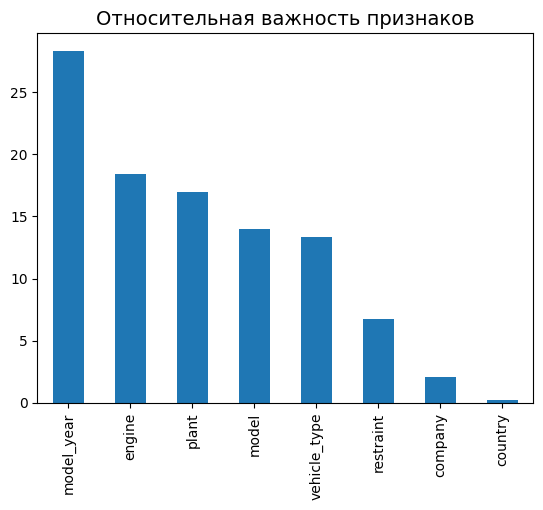

In [86]:
# Importance of the features
feature_importances = pd.DataFrame(
    {'features': list(X_train),
     'feature_importance': grid2.best_estimator_.named_steps['regr'].feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Относительная важность признаков', fontsize=14)
plt.xlabel('')
plt.show()

**Вывод**: По метрике качества RMSE лучшей моделью стал CatBoostRegressor из 186 деревьев максимальной глубиной 8 и при скорости обучения 0.1. Такая модель предсказывает конечную цену с ошибкой около 2820 на обучающей выборке и достаточно быстро обучается. Наибольшую важность для модели на "обогащенных" данных имели также модельный год ТС и тип двигателя.

In [87]:
# Evaluate the model
y_pred = grid2.predict(X_test)
print(f'Тестовая выборка MAPE = {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'Тестовая выборка RMSE = {mean_squared_error(y_test, y_pred)**0.5}')

Тестовая выборка MAPE = 0.2060743438142127
Тестовая выборка RMSE = 2808.5741189741543


Сравним полученную модель с константной.

In [88]:
# Predict with the dummy regressor (e.g., mean)
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

# Calculate scores
mape_dummy = mean_absolute_percentage_error(y_test, y_pred_dummy)
rmse_dummy = mean_squared_error(y_test, y_pred_dummy)**0.5

print(f'MAPE Dummy = {mape_dummy}')
print(f'RMSE Dummy = {rmse_dummy}')

MAPE Dummy = 1.0257382025645234
RMSE Dummy = 7839.305589736664


## Вывод
Качество модель предсказания цены ТС на основе "обогащенных" данных улучшилось незначительно. Можно быстро и без "дополнительных усилий" предсказывать цену ТС только на основе полей, полученных из VIN-кода, если ее качество приемлимо и точность цены не критична.  На тестовой выборке данная модель ошибается примерно на 2800.

Стоит обратить внимание на расшифровку кода двигателя, возможно, это повлияет на качество предсказание, так как этот признак важен.

## Применение

Менеджер магазина сможет проверять VIN-номер ТС на корректность и принадлежность к Северо-Американскому производству группы компаний FORD.
При введении номера будет также выдаваться конкретный производитель и определенная модель (или в некоторых случаях определеннЫЕ модельИ) ТС.
Для этого будет необходимо обращаться к полученным ранее таблицам для расшифровки, которые можно будет сохранить отдельно.
Кроме этого необходима будет обученная модель для предсказания цены (в последующем стоит сохранить отдельно).

Необходимые входные данные:
- wmi_tb - таблица с расшифровкой кодов производителей
- models_tb - таблица с расшифровкой моделей
- grid1 - обученная модель для предсказания цены

In [89]:
def check_vin(vin: str, wmi=wmi_tb['wmi'], models=models_tb['model']):
  # allowed charackters
  ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ['I', 'O', 'Q']]
  ALLOWED = ''.join(ALLOWED_CHARS)+'1234567890'
  result = 0
  # Check if the string has no less than 17 characters
  if len(vin) < 17:
      print("Недостаточно цифр")
  else:
    # Check if all characters are from ALLOWED
    if any(char not in ALLOWED for char in vin):
      print("Код некорректен. Есть неразрешенные символы")
    else:
      # Check if last 3 characters are digits
      pattern = r'^.*\d{3}$'
      if not re.compile(pattern).match(vin):
        print('Код некорректен. На последних 3x позициях не цифры')
      else:
        # Check if tenth character is not U or Z
        if vin[9] not in ALLOWED.replace("U", "").replace("Z", ""):
          print("Код некорректен. Год содержит неразрешенные символы")
        else:
          # Check if first three characters are from set na_wmi
          if vin[:3] in set(wmi):
            print("ТС Северо-американского производства")
            result += 1
          else:
            print("ТС НЕ произведена в Северной Америке")
          # Check if characters at position 5 to 7 are from set na_model
          if vin[4:7] in set(models):
            print("Модель из линеек FORD")
          else:
            print("Модель НЕ принадлежит северо-американским FORD")
            print("Информации о производителе и модели нет")
            print("Предсказание цены ненадежное")
          # Check if character at position 5 is T
          if vin[4] == 'T':
            print("ТС произведено не в Северной-Америке или на заводе, не принадлежащем FORD на 100%")
  return result

In [90]:
ex_vin1 = '3FAHP08Z17R268380'
check_vin(ex_vin1)

ТС Северо-американского производства
Модель из линеек FORD


1

In [91]:
ex_vin2 = 'VF1KW0C3640430030'
check_vin(ex_vin2)

ТС НЕ произведена в Северной Америке
Модель НЕ принадлежит северо-американским FORD
Информации о производителе и модели нет
Предсказание цены ненадежное


0

In [92]:
def decode_vin(vin: str, wmi=wmi_tb, models=models_tb):
  result = check_vin(vin)
  if result > 0:
    mydict={'wmi': vin[:3], 'model': vin[4:7]}
    # Create dictionary from DataFrame
    result_dict = wmi_tb.query('wmi == @mydict["wmi"]').to_dict('records')
    models = models_tb.query('model == @mydict["model"]')['description'].to_list()
    return result_dict, models

In [93]:
decode_vin(ex_vin1)

ТС Северо-американского производства
Модель из линеек FORD


([{'wmi': '3FA',
   'country': 'Mexico',
   'company': 'Ford Motor Company (Mexico)',
   'vehicle_type': 'Ford passenger car'}],
 ["Ford Escort; wagon ('81-'82)", "Ford Fusion; SEL, FWD ('06-'09)"])

In [94]:
decode_vin(ex_vin2)

ТС НЕ произведена в Северной Америке
Модель НЕ принадлежит северо-американским FORD
Информации о производителе и модели нет
Предсказание цены ненадежное


In [95]:
def predict_price(vin: str, model):
  # regexs for different parts of vin
  WMI_RE = f'(?P<wmi>[{ALLOWED}]{{3}})'         # wim, 3 chars from allowed
  RESTRAINT_RE = f'(?P<restraint>[{ALLOWED}])'  # restraint/brake systems, 1 char from allowed
  MODEL_RE = f'(?P<model>[{ALLOWED}]{{3}})'     # model of vehicle, 3 chars from allowed
  ENGINE_RE = f'(?P<engine>[{ALLOWED}])'        # engine, 1 char from allowed
  CHECK_RE = f'(?P<check>[{ALLOWED}])'          # check digit, 1 char from allowed
  YEAR_RE = f'(?P<year>[{ALLOWED.replace("U", "").replace("Z", "")}])' # year, 1 char from allowed without 'U' and 'Z'
  PLANT_RE = f'(?P<plant>[{ALLOWED}])'          # plant, 1 char from allowed
  VIS_RE = f'(?P<vis>[{ALLOWED}]{{3}}\\d{{3}})' # vis, 3 chars from allowed+3digits
  # regexs to parse vin
  VIN_RE = f'{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}'
  # complite pattern
  pattern = re.compile(VIN_RE)
  # create data frame
  pred = (pd.DataFrame(x.groupdict() for x in pattern.finditer(vin))
  .drop(['check', 'vis'], axis=1))
  print('Примерная цена')
  return round(model.predict(pred).item())

In [96]:
predict_price(ex_vin1, grid1)

Примерная цена


3778

In [97]:
predict_price(ex_vin2, grid1)

Примерная цена


4214

In [98]:
class CheckVin:
    def __init__(self, wmi_tb, models_tb):
        self.wmi_tb = wmi_tb
        self.models_tb = models_tb
        self.ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ['I', 'O', 'Q']]
        self.ALLOWED = ''.join(self.ALLOWED_CHARS) + '1234567890'

    def check_vin(self, vin):
        result = 0
        if len(vin) < 17:
            print("Недостаточно цифр")
        elif any(char not in self.ALLOWED for char in vin):
            print("Код некорректен. Есть неразрешенные символы")
        elif not re.compile(r'^.*\d{3}$').match(vin):
            print('Код некорректен. На последних 3x позициях не цифры')
        elif vin[9] not in self.ALLOWED.replace("U", "").replace("Z", ""):
            print("Код некорректен. Год содержит неразрешенные символы")
        else:
            if vin[:3] in set(self.wmi_tb['wmi']):
                print("ТС Северо-американского производства")
                result += 1
            else:
                print("ТС НЕ произведена в Северной Америке")
            if vin[4:7] in set(self.models_tb['model']):
                print("Модель из линеек FORD")
            else:
                print("Модель НЕ принадлежит северо-американским FORD")
                print("Информации о производителе и модели нет")
                print("Предсказание цены ненадежное")
            if vin[4] == 'T':
                print("ТС произведено не в Северной-Америке или на заводе, не принадлежащем FORD на 100%")
        return result

    def decode_vin(self, vin):
        result = self.check_vin(vin)
        if result > 0:
            mydict = {'wmi': vin[:3], 'model': vin[4:7]}
            result_dict = self.wmi_tb.query('wmi == @mydict["wmi"]').to_dict('records')
            models = self.models_tb.query('model == @mydict["model"]')['description'].tolist()
            return result_dict, models

    def predict_price(self, vin, model):
        WMI_RE = f'(?P<wmi>[{self.ALLOWED}]{{3}})'
        RESTRAINT_RE = f'(?P<restraint>[{self.ALLOWED}])'
        MODEL_RE = f'(?P<model>[{self.ALLOWED}]{{3}})'
        ENGINE_RE = f'(?P<engine>[{self.ALLOWED}])'
        CHECK_RE = f'(?P<check>[{self.ALLOWED}])'
        YEAR_RE = f'(?P<year>[{self.ALLOWED.replace("U", "").replace("Z", "")}])'
        PLANT_RE = f'(?P<plant>[{self.ALLOWED}])'
        VIS_RE = f'(?P<vis>[{self.ALLOWED}]{{3}}\\d{{3}})'
        VIN_RE = f'{WMI_RE}{RESTRAINT_RE}{MODEL_RE}{ENGINE_RE}{CHECK_RE}{YEAR_RE}{PLANT_RE}{VIS_RE}'
        pattern = re.compile(VIN_RE)
        pred = (pd.DataFrame(x.groupdict() for x in pattern.finditer(vin))
                .drop(['check', 'vis'], axis=1))
        print('Примерная цена')
        return round(model.predict(pred).item())


In [99]:
# Example usage
check_vin = CheckVin(wmi_tb, models_tb)
check_vin.check_vin('1FTFX1EF2EKE24350')

ТС Северо-американского производства
Модель из линеек FORD


1

In [100]:
check_vin.decode_vin('1FTFX1EF2EKE24350')

ТС Северо-американского производства
Модель из линеек FORD


([{'wmi': '1FT',
   'country': 'USA',
   'company': 'Ford Motor Company',
   'vehicle_type': 'Ford truck (completed vehicle)'}],
 ["Ford F-Series, F-150, Super Cab, Styleside, 4WD ('10-'23); F-150 Raptor, Super Cab, Styleside, 4WD ('10)"])

In [101]:
check_vin.predict_price('1FTFX1EF2EKE24350', grid1)

Примерная цена


23895

In [102]:
check_vin.check_vin('VF1KW0C3640430030')

ТС НЕ произведена в Северной Америке
Модель НЕ принадлежит северо-американским FORD
Информации о производителе и модели нет
Предсказание цены ненадежное


0

In [103]:
check_vin.decode_vin('VF1KW0C3640430030')

ТС НЕ произведена в Северной Америке
Модель НЕ принадлежит северо-американским FORD
Информации о производителе и модели нет
Предсказание цены ненадежное


In [104]:
check_vin.predict_price('VF1KW0C3640430030', grid1)

Примерная цена


4214